# Project Name: Dividend Pattern Recognition as Time Series Model

### 1. Backgroud

BDVD provids Dividend Forecast for 3112 JP tickers, manually. 

Through experience we know there are several patterns, such as Constant Dividend Amount, Constant Increase Rate, etc. 

Use Time Series Models (AR, MA, ARMA, VAR, Logistic, LSTM, Naive Bayesian...) to analyze Historical Dividend data. 

Demo Example: Annual Constant Dividend 

### 2. Steps 

1. Import Data
2. Pre-process 
3. Apply Models
4. Analyze Results


In [76]:
%install pyrefdata 0.2.0


In [ ]:
df.index[df['IHM(DMA)']==x].tolist()

In [77]:
from pandas import Series
import matplotlib.pyplot as plt
from matplotlib import pyplot
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
from pandas.tseries.offsets import BDay
import calendar

from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import re
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA

import bqapi
import bql
import pyrefdata
from pyrefdata import get_data, find_by_domain, get_historical_data


import datetime as dt
from datetime import datetime, date, timedelta



bq = bql.Service()
sess = bqapi.Session()

In [78]:
tickername = ('7201 JP Equity')

In [79]:
hisdiv = get_data(sess, tickername , "DV030", ignore_errors = True) 
calendar_dict =  {'JP':'TK','KS':'SE'}
currency_dict = {'JP':'JPY', 'KS':'KRW'}
netorgross_dict = {'JP':'NONE', 'KS':'GROSS'}


In [80]:
temp = []
hisdiv = get_data(sess, tickername , "DV030", ignore_errors = True) 
hisdiv = hisdiv['DV030']
    # DV030 is the FLDS for History Dividend data
if hisdiv['Dividend Amount'][0] < 0:
        # Delete the latest data if the latest dividend is TBA
    hisdiv = hisdiv[1:]
    abshisdiv = hisdiv[['Declared Date', 'Dividend Amount', 'Dividend Frequency','Dividend Type', 'Ex-Date', 'Payable Date', 'Record Date']]
        # abstract of historical data
    fre = get_data(sess, tickername , "DV016")
        #'''DV016 is the FLDS for latest dividend frequency''' 
    abshisdiv_fre = abshisdiv[abshisdiv['Dividend Frequency'] == fre['DV016'].values[0]]
    dec_abshisdiv_fre = abshisdiv_fre['Declared Date'].values
    pay_abshisdiv_fre = abshisdiv_fre['Payable Date'].values
    re_abshisdiv_fre = abshisdiv_fre['Record Date'].values
else: 
    abshisdiv = hisdiv[['Declared Date', 'Dividend Amount', 'Dividend Frequency','Dividend Type', 'Ex-Date', 'Payable Date', 'Record Date']]
        #'''abstract of historical data'''
    fre = get_data(sess, tickername , "DV016")
        # '''DV016 is the FLDS for latest dividend frequency''' 
    abshisdiv_fre = abshisdiv[abshisdiv['Dividend Frequency'] == fre['DV016'].values[0]]
    dec_abshisdiv_fre = abshisdiv_fre['Declared Date'].values
    pay_abshisdiv_fre = abshisdiv_fre['Payable Date'].values
    re_abshisdiv_fre = abshisdiv_fre['Record Date'].values
fre_dict = {'Annual':1,'Semi-Anl':2, 'Quarter':4, 'Monthly':12}


In [81]:
nonsettle = get_data(sess, tickername , "ZS090", overrides = {'ZS087': calendar_dict[tickername.split(' ')[1]]}, ignore_errors = True) 
#TODO here TK is the Tokyo Stock Exchange code, can be replaced by other region codes 
nonsetlist = nonsettle['ZS090']['Holiday Date'].tolist()


In [82]:
decdate = []
for t in range(1,6):
        #'''Provide future 5 years of forecast, thus range(1, 6)'''
    x = fre_dict[fre['DV016'].values[0]]
    for item in dec_abshisdiv_fre[:x]:
        decdate.append(item + dt.timedelta(days = 365*t))
        # '''Simply add 365 days to the Historical Dec-dates'''
decdate.sort(reverse = True)

In [83]:
adjustedecdate = []
def adjustdate(x):
    for decdatei in x:
        while decdatei.weekday() > 4 or decdatei in set(nonsetlist):
            decdatei = decdatei + dt.timedelta(days = 1)
        adjustedecdate.append(dt.date.strftime(decdatei, '%m/%d/%Y'))
    return adjustedecdate
adjustdate(decdate)

['11/07/2023',
 '05/15/2023',
 '11/07/2022',
 '05/13/2022',
 '11/08/2021',
 '05/13/2021',
 '11/09/2020',
 '05/13/2020',
 '11/08/2019',
 '05/14/2019']

In [84]:
paydate = []
pay_abshisdiv_fre_tolist = pay_abshisdiv_fre.tolist()
for t in range(1,6):
    x = fre_dict[fre['DV016'].values[0]]
    for item in pay_abshisdiv_fre[pay_abshisdiv_fre_tolist[:x].count(None): x + pay_abshisdiv_fre_tolist[:x].count(None)]:
        paydate.append(item + dt.timedelta(days = 365*(t+1)))
paydate.sort(reverse = True)
paydate


[datetime.date(2025, 6, 24),
 datetime.date(2024, 11, 26),
 datetime.date(2024, 6, 24),
 datetime.date(2023, 11, 27),
 datetime.date(2023, 6, 25),
 datetime.date(2022, 11, 27),
 datetime.date(2022, 6, 25),
 datetime.date(2021, 11, 27),
 datetime.date(2021, 6, 25),
 datetime.date(2020, 11, 27)]

In [85]:
adjustepaydate = []
def adjustdate(x):
    for datei in x:
        while datei.weekday() > 4 or datei in set(nonsetlist):
            datei = datei + dt.timedelta(days = 1)
        adjustepaydate.append(dt.date.strftime(datei, '%m/%d/%Y'))
    return adjustepaydate
adjustdate(paydate)

['06/24/2025',
 '11/26/2024',
 '06/24/2024',
 '11/27/2023',
 '06/26/2023',
 '11/28/2022',
 '06/27/2022',
 '11/29/2021',
 '06/25/2021',
 '11/27/2020']

In [86]:
recorddate = []
def check_if_last_day_of_month(date):
    last_day_of_month = calendar.monthrange(date.year, date.month)[1]
    # here i check if date is last day of month
    if date == dt.date(date.year, date.month, last_day_of_month):
        return True
    return False

for t in range(1,6):
    x = fre_dict[fre['DV016'].values[0]]
    for item in re_abshisdiv_fre[:x]:
        if item.month == 2 and check_if_last_day_of_month(item)==1:
            last_day_of_month = calendar.monthrange(item.year + t, item.month)[1]
            recorddate.append(dt.date(item.year + t, item.month, last_day_of_month))
        else:
            recorddate.append(dt.date(item.year + t, item.month, item.day))
            
recorddate.sort(reverse = True)
finalrecorddate = [dt.date.strftime(i, '%m/%d/%Y') for i in recorddate]


In [87]:
exdate = []
def settlementrule(x):
    for item in x: 
        while item.weekday() > 4 or item in set(nonsetlist): 
            item = item + dt.timedelta(days = -1)
        else:
            item = item + dt.timedelta(days = -1)
            while item.weekday() > 4 or item in set(nonsetlist): 
                item = item + dt.timedelta(days = -1)
        exdate.append(item)
    return exdate

    
    

In [88]:
settlementrule(recorddate)
exdate = [dt.date.strftime(i, '%m/%d/%Y') for i in exdate]

In [89]:
entrydate = [dt.date.today()]*(5*fre_dict[fre['DV016'].values[0]])
entrydate = [dt.date.strftime(i, '%m/%d/%Y') for i in entrydate]

In [90]:
dates = {'declarationDate': adjustedecdate, 'exDate': exdate, 'entryDate': entrydate, 
     'recordDate': recorddate, 'payDate': adjustepaydate}

In [91]:
fiscalyear = []
lists = []
for l in range(1, 6):
    lists.append([abshisdiv_fre['Record Date'][0].year + 6- l]*fre_dict[fre['DV016'].values[0]] )
for sublist in lists:
    for item in sublist:
        fiscalyear.append(item)


In [92]:
peri_dict = {'Annual':['A'],'Semi-Anl':['S2', 'S1'], 'Quarter':['Q4', 'Q3', 'Q2', 'Q1'], 'Monthly':['M12', 'M11','M10', 'M9', 'M8', 'M7', 'M6', 'M5', 'M4', 'M3', 'M2', 'M1']}


In [93]:
fiscalperiod = peri_dict[fre['DV016'].values[0]]*5


In [94]:
timesayear = [fre_dict[fre['DV016'].values[0]]]*5*fre_dict[fre['DV016'].values[0]]


In [95]:
type_dict = {'Annual':['REGULAR_CASH'],'Semi-Anl':['FINAL', 'INTERIM'], 'Quarter':['FINAL', 'THIRD_INTERIM', 'SECOND_INTERIM', 'FIRST_INTERIM'], 
         'Monthly':['INCOME', 'INCOME','INCOME', 'INCOME', 'INCOME', 'INCOME', 'INCOME', 'INCOME', 'INCOME', 'INCOME', 'INCOME', 'INCOME']}

In [96]:
dividendtype = type_dict[fre['DV016'].values[0]]*5


In [97]:
currency = [currency_dict[tickername.split(' ')[1]]]*5*fre_dict[fre['DV016'].values[0]]
currency
# please change to local currency if not JP or KS

['JPY', 'JPY', 'JPY', 'JPY', 'JPY', 'JPY', 'JPY', 'JPY', 'JPY', 'JPY']

In [98]:
netorgross = [netorgross_dict[tickername.split(' ')[1]]]*5*fre_dict[fre['DV016'].values[0]]
netorgross
# please change to Gross or Net or None according to local convention if not JP or KS

['NONE',
 'NONE',
 'NONE',
 'NONE',
 'NONE',
 'NONE',
 'NONE',
 'NONE',
 'NONE',
 'NONE']

In [99]:
temp = []

w = hisdiv[['Declared Date', 'Dividend Amount', 'Dividend Frequency','Dividend Type']]
div_amount = w[w['Dividend Frequency'] == fre['DV016'].values[0]]
div_amount = div_amount['Dividend Amount'].values
time_order_div = div_amount[::-1]   
# if cancelled, omitted, or TBA, then negative values
time_order_div = [item for item in time_order_div if item > 0]
# assign weight vector to historical dividends
weight = np.zeros(len(time_order_div))
# for default we don't assign weight
# assign weights to "weight" and then mutiply two vectors
# split dataset
if len(time_order_div) > 2:
    for j in range(1, 13):
        try:
            train, test = time_order_div[0:len(time_order_div)-j], time_order_div[len(time_order_div)-j:]   # train autoregression
            model = AR(train)
            model_fit = model.fit() 
        # make prediction
            predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
            error = mean_squared_error(test, predictions)
            temp.append((tickername, model_fit.k_ar, j, error, time_order_div[-1], error/time_order_div[-1]))
        except ValueError:
            continue



In [101]:
temp

[('7201 JP Equity', 10, 1, 0.033459612134353341, 28.5, 0.0011740214783983627),
 ('7201 JP Equity', 10, 2, 5.2055840410579606, 28.5, 0.18265207161606878),
 ('7201 JP Equity', 10, 3, 10.696967559381923, 28.5, 0.37533219506603238),
 ('7201 JP Equity', 10, 4, 25.241242333318237, 28.5, 0.88565762573046447),
 ('7201 JP Equity', 10, 5, 54.667212044033633, 28.5, 1.9181477910187239),
 ('7201 JP Equity', 9, 6, 100.9326460356915, 28.5, 3.5414963521295264),
 ('7201 JP Equity', 9, 7, 96.457182019679223, 28.5, 3.3844625270062885),
 ('7201 JP Equity', 9, 8, 164.34633260807001, 28.5, 5.7665379862480703),
 ('7201 JP Equity', 9, 9, 154.00661954903927, 28.5, 5.4037410368083956),
 ('7201 JP Equity', 9, 10, 151.64320378131708, 28.5, 5.3208141677655121),
 ('7201 JP Equity', 9, 11, 191.3245013443304, 28.5, 6.7131403980466811),
 ('7201 JP Equity', 9, 12, 857.54895097710221, 28.5, 30.089436876389552)]

In [102]:
# Turn the results into DataFrame
col = ['Ticker', 'Lag', 'Test Length', 'MSE', 'Last Dividend', 'Ratio']
df = pd.DataFrame(temp, columns = col)
df.head()

,Ticker,Lag,Test Length,MSE,Last Dividend,Ratio
0,7201 JP Equity,10,1,0.0335,28.5000,0.0012
1,7201 JP Equity,10,2,5.2056,28.5000,0.1827
2,7201 JP Equity,10,3,10.6970,28.5000,0.3753
3,7201 JP Equity,10,4,25.2412,28.5000,0.8857
4,7201 JP Equity,10,5,54.6672,28.5000,1.9181


In [103]:
# Only keep the minimun MSE record for each ticker
dfs = df.sort_values(by = ['Ticker', 'MSE'], ascending = True)
dfsfinal = dfs.drop_duplicates(subset = 'Ticker', keep = 'first')
pd.options.display.float_format = '{:.4f}'.format
# make the numerical number into 0.0000 format 
dfsfinal.head()

,Ticker,Lag,Test Length,MSE,Last Dividend,Ratio
0,7201 JP Equity,10,1,0.0335,28.5000,0.0012


predicted=-7.466928, expected=0.000000
length=1
num=1
i=0
Test MSE: 55.904
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


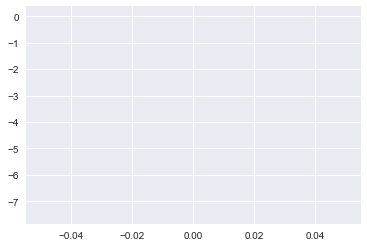

[-7.47692812]
--------------------------------------------
predicted=29.269852, expected=0.000000
predicted=28.800954, expected=0.000000
length=1
num=2
i=1
Test MSE: 842.529
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


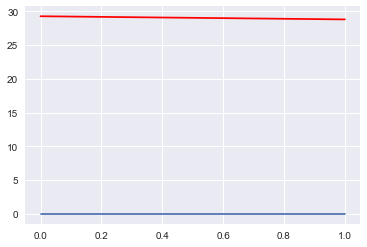

[ 28.79095445  29.25985222]
--------------------------------------------
predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
length=1
num=3
i=2
Test MSE: 572.304
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


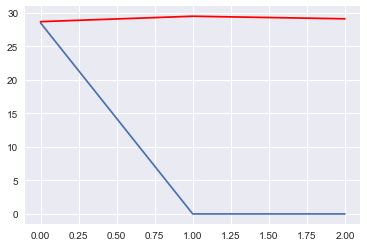

[ 29.10776487  29.48924876  28.68291969]
--------------------------------------------
predicted=26.411311, expected=28.500000
predicted=26.059148, expected=28.500000
predicted=25.877167, expected=0.000000
predicted=25.848972, expected=0.000000
length=1
num=4
i=3
Test MSE: 336.793
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


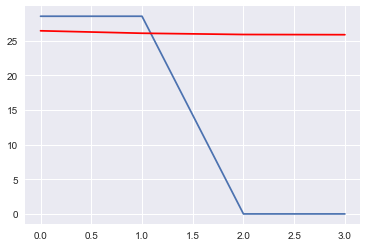

[ 25.83897163  25.8671667   26.04914847  26.40131115]
--------------------------------------------
predicted=25.397655, expected=26.500000
predicted=25.029551, expected=28.500000
predicted=24.181020, expected=28.500000
predicted=24.229873, expected=0.000000
predicted=23.817438, expected=0.000000
length=1
num=5
i=4
Test MSE: 237.097
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


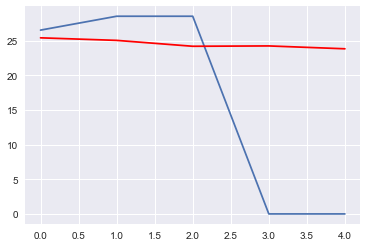

[ 23.80743798  24.2198733   24.17102025  25.01955083  25.38765537]
--------------------------------------------
predicted=24.747792, expected=26.500000
predicted=23.242317, expected=26.500000
predicted=22.133070, expected=28.500000
predicted=21.689692, expected=28.500000
predicted=21.192883, expected=0.000000
predicted=20.798967, expected=0.000000
length=1
num=6
i=5
Test MSE: 163.643
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


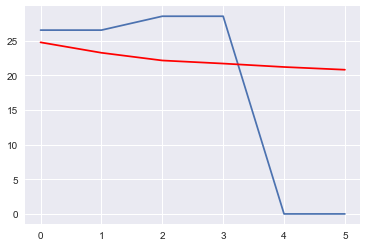

[ 20.78896672  21.18288298  21.67969179  22.12307     23.23231683
  24.73779237]
--------------------------------------------
predicted=21.589501, expected=24.000000
predicted=21.917495, expected=26.500000
predicted=19.463911, expected=26.500000
predicted=19.119178, expected=28.500000
predicted=18.091207, expected=28.500000
predicted=17.855185, expected=0.000000
predicted=17.361427, expected=0.000000
length=1
num=7
i=6
Test MSE: 127.551
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


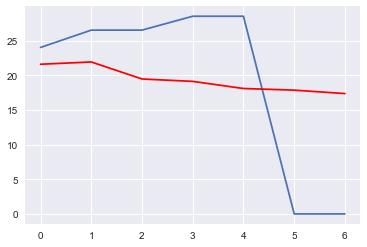

[ 17.35142748  17.84518481  18.08120718  19.10917832  19.45391104
  21.90749509  21.57950141]
--------------------------------------------
predicted=20.561780, expected=24.000000
predicted=18.083195, expected=24.000000
predicted=17.240652, expected=26.500000
predicted=16.367527, expected=26.500000
predicted=15.165683, expected=28.500000
predicted=14.663800, expected=28.500000
predicted=14.026761, expected=0.000000
predicted=14.108905, expected=0.000000
length=1
num=8
i=7
Test MSE: 125.106
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


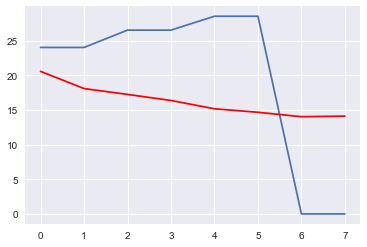

[ 14.09890532  14.01676119  14.6538001   15.15568254  16.35752657
  17.23065174  18.07319537  20.55178041]
--------------------------------------------
predicted=20.390623, expected=21.000000
predicted=19.871436, expected=24.000000
predicted=17.262411, expected=24.000000
predicted=16.669775, expected=26.500000
predicted=15.725032, expected=26.500000
predicted=14.618108, expected=28.500000
predicted=14.156298, expected=28.500000
predicted=13.590735, expected=0.000000
predicted=13.704633, expected=0.000000
length=1
num=9
i=8
Test MSE: 116.353
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


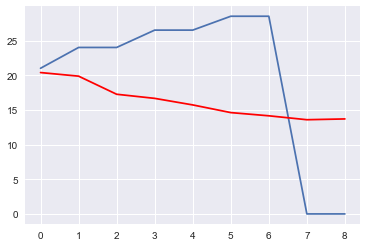

[ 13.69463286  13.58073539  14.14629847  14.6081079   15.71503181
  16.65977532  17.25241074  19.86143601  20.3806234 ]
--------------------------------------------
predicted=15.230777, expected=21.000000
predicted=14.207415, expected=21.000000
predicted=12.668864, expected=24.000000
predicted=12.771142, expected=24.000000
predicted=11.759313, expected=26.500000
predicted=12.075906, expected=26.500000
predicted=11.672438, expected=28.500000
predicted=12.056021, expected=28.500000
predicted=12.080218, expected=0.000000
predicted=12.171392, expected=0.000000
length=1
num=10
i=9
Test MSE: 160.836
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


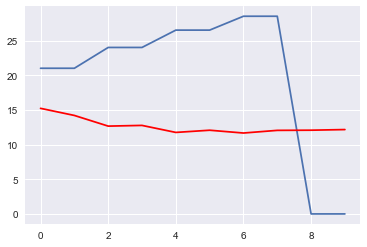

[ 12.16139209  12.07021783  12.04602085  11.6624376   12.06590579
  11.74931339  12.76114181  12.65886366  14.19741472  15.22077693]
--------------------------------------------
predicted=15.678083, expected=16.500000
predicted=14.346772, expected=21.000000
predicted=13.240593, expected=21.000000
predicted=12.119577, expected=24.000000
predicted=12.220136, expected=24.000000
predicted=11.403072, expected=26.500000
predicted=11.859339, expected=26.500000
predicted=11.551231, expected=28.500000
predicted=12.085593, expected=28.500000
predicted=12.057614, expected=0.000000
predicted=12.256899, expected=0.000000
length=1
num=11
i=10
Test MSE: 152.836
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


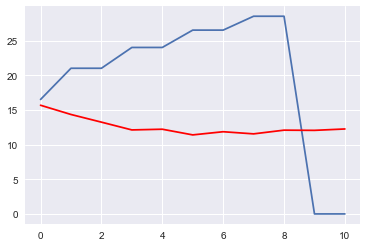

[ 12.24689948  12.04761379  12.07559282  11.54123102  11.84933916
  11.39307188  12.21013565  12.10957684  13.23059315  14.33677204
  15.6680833 ]
--------------------------------------------
predicted=13.861868, expected=16.500000
predicted=13.021167, expected=16.500000
predicted=11.853177, expected=21.000000
predicted=12.168400, expected=21.000000
predicted=11.142197, expected=24.000000
predicted=11.536891, expected=24.000000
predicted=11.291734, expected=26.500000
predicted=11.784381, expected=26.500000
predicted=11.734029, expected=28.500000
predicted=11.651924, expected=28.500000
predicted=11.767235, expected=0.000000
predicted=11.566531, expected=0.000000
length=1
num=12
i=11
Test MSE: 149.018
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0. ]


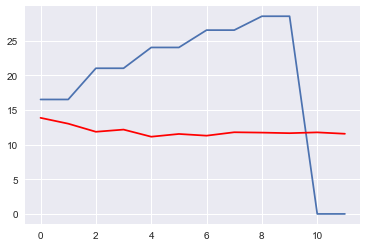

[ 11.55653128  11.75723499  11.64192418  11.72402942  11.77438135
  11.28173426  11.52689065  11.13219669  12.15839986  11.84317736
  13.01116708  13.85186782]
--------------------------------------------
predicted=9.086044, expected=15.000000
predicted=5.994907, expected=16.500000
predicted=5.791137, expected=16.500000
predicted=9.533472, expected=21.000000
predicted=11.241750, expected=21.000000
predicted=11.225704, expected=24.000000
predicted=12.673841, expected=24.000000
predicted=12.641613, expected=26.500000
predicted=10.459385, expected=26.500000
predicted=7.371701, expected=28.500000
predicted=7.818049, expected=28.500000
predicted=10.361085, expected=0.000000
predicted=11.643213, expected=0.000000
length=1
num=13
i=12
Test MSE: 180.542
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   2

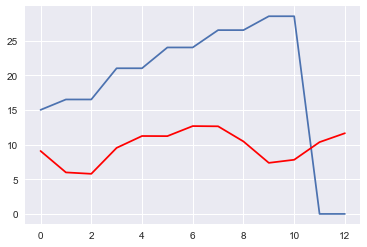

[ 11.6332126   10.35108506   7.80804943   7.36170064  10.44938548
  12.63161261  12.66384074  11.21570406  11.23175015   9.52347172
   5.78113682   5.98490675   9.07604426]
--------------------------------------------
predicted=1.777966, expected=15.000000
predicted=-14.698661, expected=15.000000
predicted=-18.209361, expected=16.500000
predicted=-4.213831, expected=16.500000
predicted=10.400390, expected=21.000000
predicted=18.884427, expected=21.000000
predicted=21.638266, expected=24.000000
predicted=9.991386, expected=24.000000
predicted=-17.886088, expected=26.500000
predicted=-34.272560, expected=26.500000
predicted=-11.315923, expected=28.500000
predicted=33.717683, expected=28.500000
predicted=64.749542, expected=0.000000
predicted=67.143561, expected=0.000000
length=1
num=14
i=13
Test MSE: 1356.336
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.  

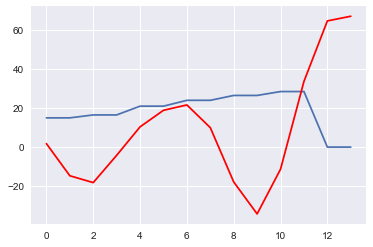

[ 67.13356107  64.73954195  33.70768259 -11.3259233  -34.28256008
 -17.8960881    9.98138577  21.62826644  18.87442743  10.39038966
  -4.22383114 -18.2193608  -14.70866143   1.76796585]
--------------------------------------------
predicted=11.399361, expected=12.500000
predicted=-0.153334, expected=15.000000
predicted=-16.471840, expected=15.000000
predicted=-18.648072, expected=16.500000
predicted=-3.690313, expected=16.500000
predicted=11.536862, expected=21.000000
predicted=19.965988, expected=21.000000
predicted=20.318499, expected=24.000000
predicted=5.051621, expected=24.000000
predicted=-23.251485, expected=26.500000
predicted=-34.561343, expected=26.500000
predicted=-5.214239, expected=28.500000
predicted=42.965924, expected=28.500000
predicted=72.560678, expected=0.000000
predicted=67.653705, expected=0.000000
length=1
num=15
i=14
Test MSE: 1381.451
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   

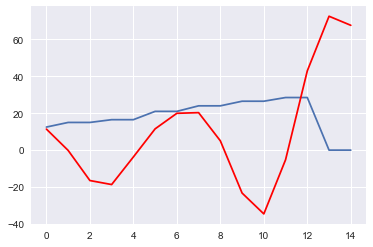

[ 67.64370549  72.55067807  42.95592392  -5.22423888 -34.57134327
 -23.2614851    5.04162101  20.30849863  19.95598817  11.52686232
  -3.70031346 -18.65807179 -16.48184011  -0.16333442  11.38936117]
--------------------------------------------
predicted=-7.181528, expected=0.000000
predicted=1.900011, expected=0.000000
length=2
num=2
i=1
Test MSE: 27.645
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


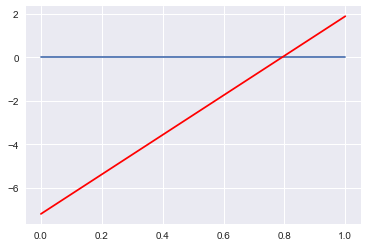

[ 1.89001053 -7.19152833]
--------------------------------------------
predicted=-7.466928, expected=0.000000
predicted=-15.138014, expected=0.000000
predicted=-6.608876, expected=0.000000
length=2
num=3
i=2
Test MSE: 109.725
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


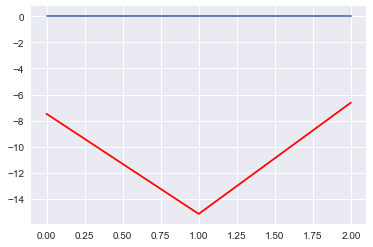

[ -6.61887633 -15.14801427  -7.47692812]
--------------------------------------------
predicted=29.269852, expected=0.000000
predicted=28.800954, expected=0.000000
predicted=29.309213, expected=0.000000
predicted=29.503770, expected=0.000000
length=2
num=4
i=3
Test MSE: 853.346
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


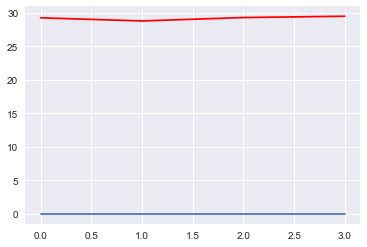

[ 29.4937698   29.29921289  28.79095445  29.25985222]
--------------------------------------------
predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
predicted=29.597794, expected=0.000000
predicted=29.866199, expected=0.000000
length=2
num=5
i=4
Test MSE: 696.748
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


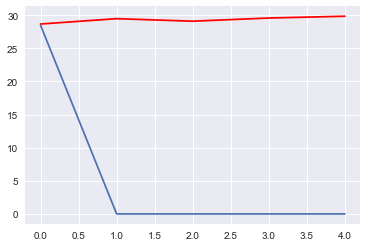

[ 29.85619913  29.58779404  29.10776487  29.48924876  28.68291969]
--------------------------------------------
predicted=26.411311, expected=28.500000
predicted=26.059148, expected=28.500000
predicted=25.877167, expected=0.000000
predicted=25.848972, expected=0.000000
predicted=25.527884, expected=0.000000
predicted=25.588177, expected=0.000000
length=2
num=6
i=5
Test MSE: 442.097
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


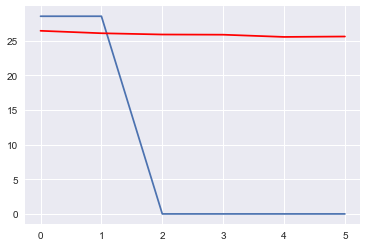

[ 25.57817723  25.517884    25.83897163  25.8671667   26.04914847
  26.40131115]
--------------------------------------------
predicted=25.397655, expected=26.500000
predicted=25.029551, expected=28.500000
predicted=24.181020, expected=28.500000
predicted=24.229873, expected=0.000000
predicted=23.817438, expected=0.000000
predicted=23.446833, expected=0.000000
predicted=23.365917, expected=0.000000
length=2
num=7
i=6
Test MSE: 325.753
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


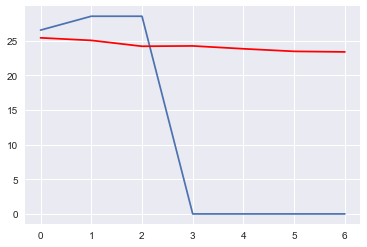

[ 23.35591727  23.43683276  23.80743798  24.2198733   24.17102025
  25.01955083  25.38765537]
--------------------------------------------
predicted=24.747792, expected=26.500000
predicted=23.242317, expected=26.500000
predicted=22.133070, expected=28.500000
predicted=21.689692, expected=28.500000
predicted=21.192883, expected=0.000000
predicted=20.798967, expected=0.000000
predicted=20.280576, expected=0.000000
predicted=20.111334, expected=0.000000
length=2
num=8
i=7
Test MSE: 224.603
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


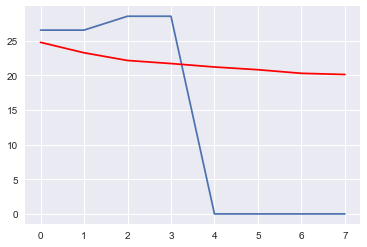

[ 20.10133441  20.2705762   20.78896672  21.18288298  21.67969179  22.12307
  23.23231683  24.73779237]
--------------------------------------------
predicted=21.589501, expected=24.000000
predicted=21.917495, expected=26.500000
predicted=19.463911, expected=26.500000
predicted=19.119178, expected=28.500000
predicted=18.091207, expected=28.500000
predicted=17.855185, expected=0.000000
predicted=17.361427, expected=0.000000
predicted=16.937678, expected=0.000000
predicted=16.582571, expected=0.000000
length=2
num=9
i=8
Test MSE: 161.562
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


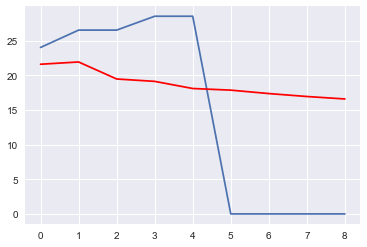

[ 16.57257064  16.92767772  17.35142748  17.84518481  18.08120718
  19.10917832  19.45391104  21.90749509  21.57950141]
--------------------------------------------
predicted=20.561780, expected=24.000000
predicted=18.083195, expected=24.000000
predicted=17.240652, expected=26.500000
predicted=16.367527, expected=26.500000
predicted=15.165683, expected=28.500000
predicted=14.663800, expected=28.500000
predicted=14.026761, expected=0.000000
predicted=14.108905, expected=0.000000
predicted=13.333332, expected=0.000000
predicted=13.096630, expected=0.000000
length=2
num=10
i=9
Test MSE: 134.962
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


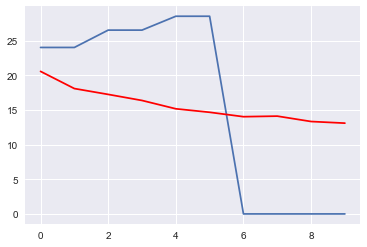

[ 13.0866303   13.32333223  14.09890532  14.01676119  14.6538001
  15.15568254  16.35752657  17.23065174  18.07319537  20.55178041]
--------------------------------------------
predicted=20.390623, expected=21.000000
predicted=19.871436, expected=24.000000
predicted=17.262411, expected=24.000000
predicted=16.669775, expected=26.500000
predicted=15.725032, expected=26.500000
predicted=14.618108, expected=28.500000
predicted=14.156298, expected=28.500000
predicted=13.590735, expected=0.000000
predicted=13.704633, expected=0.000000
predicted=12.930157, expected=0.000000
predicted=12.789491, expected=0.000000
length=2
num=11
i=10
Test MSE: 125.220
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. ]


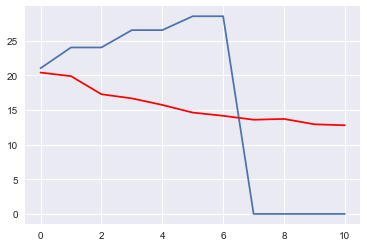

[ 12.77949057  12.92015678  13.69463286  13.58073539  14.14629847
  14.6081079   15.71503181  16.65977532  17.25241074  19.86143601
  20.3806234 ]
--------------------------------------------
predicted=15.230777, expected=21.000000
predicted=14.207415, expected=21.000000
predicted=12.668864, expected=24.000000
predicted=12.771142, expected=24.000000
predicted=11.759313, expected=26.500000
predicted=12.075906, expected=26.500000
predicted=11.672438, expected=28.500000
predicted=12.056021, expected=28.500000
predicted=12.080218, expected=0.000000
predicted=12.171392, expected=0.000000
predicted=12.384731, expected=0.000000
predicted=12.203427, expected=0.000000
length=2
num=12
i=11
Test MSE: 159.181
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0

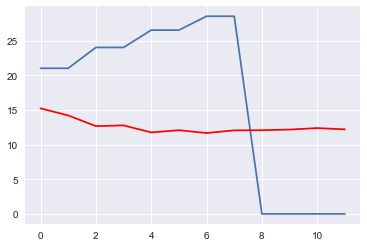

[ 12.19342746  12.37473132  12.16139209  12.07021783  12.04602085
  11.6624376   12.06590579  11.74931339  12.76114181  12.65886366
  14.19741472  15.22077693]
--------------------------------------------
predicted=15.678083, expected=16.500000
predicted=14.346772, expected=21.000000
predicted=13.240593, expected=21.000000
predicted=12.119577, expected=24.000000
predicted=12.220136, expected=24.000000
predicted=11.403072, expected=26.500000
predicted=11.859339, expected=26.500000
predicted=11.551231, expected=28.500000
predicted=12.085593, expected=28.500000
predicted=12.057614, expected=0.000000
predicted=12.256899, expected=0.000000
predicted=12.328933, expected=0.000000
predicted=12.189252, expected=0.000000
length=2
num=13
i=12
Test MSE: 152.406
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.

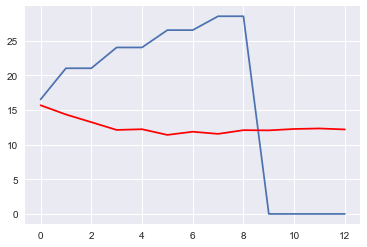

[ 12.17925199  12.31893294  12.24689948  12.04761379  12.07559282
  11.54123102  11.84933916  11.39307188  12.21013565  12.10957684
  13.23059315  14.33677204  15.6680833 ]
--------------------------------------------
predicted=13.861868, expected=16.500000
predicted=13.021167, expected=16.500000
predicted=11.853177, expected=21.000000
predicted=12.168400, expected=21.000000
predicted=11.142197, expected=24.000000
predicted=11.536891, expected=24.000000
predicted=11.291734, expected=26.500000
predicted=11.784381, expected=26.500000
predicted=11.734029, expected=28.500000
predicted=11.651924, expected=28.500000
predicted=11.767235, expected=0.000000
predicted=11.566531, expected=0.000000
predicted=11.734658, expected=0.000000
predicted=11.454775, expected=0.000000
length=2
num=14
i=13
Test MSE: 146.905
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.  

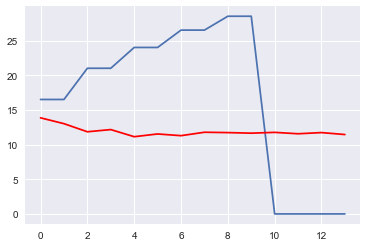

[ 11.44477492  11.7246582   11.55653128  11.75723499  11.64192418
  11.72402942  11.77438135  11.28173426  11.52689065  11.13219669
  12.15839986  11.84317736  13.01116708  13.85186782]
--------------------------------------------
predicted=9.086044, expected=15.000000
predicted=5.994907, expected=16.500000
predicted=5.791137, expected=16.500000
predicted=9.533472, expected=21.000000
predicted=11.241750, expected=21.000000
predicted=11.225704, expected=24.000000
predicted=12.673841, expected=24.000000
predicted=12.641613, expected=26.500000
predicted=10.459385, expected=26.500000
predicted=7.371701, expected=28.500000
predicted=7.818049, expected=28.500000
predicted=10.361085, expected=0.000000
predicted=11.643213, expected=0.000000
predicted=11.693436, expected=0.000000
predicted=11.838827, expected=0.000000
length=2
num=15
i=14
Test MSE: 174.898
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   

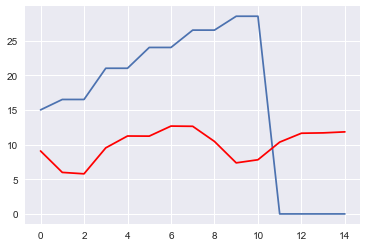

[ 11.82882738  11.68343592  11.6332126   10.35108506   7.80804943
   7.36170064  10.44938548  12.63161261  12.66384074  11.21570406
  11.23175015   9.52347172   5.78113682   5.98490675   9.07604426]
--------------------------------------------
predicted=8.259066, expected=0.000000
predicted=1.918196, expected=0.000000
predicted=3.087066, expected=0.000000
length=3
num=3
i=2
Test MSE: 27.052
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


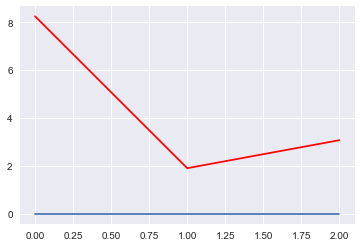

[ 3.07706643  1.90819643  8.24906595]
--------------------------------------------
predicted=-7.181528, expected=0.000000
predicted=1.900011, expected=0.000000
predicted=-3.935072, expected=0.000000
predicted=-0.530855, expected=0.000000
length=3
num=4
i=3
Test MSE: 17.787
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


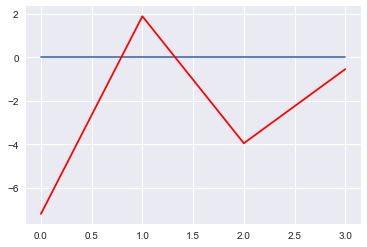

[-0.54085478 -3.94507248  1.89001053 -7.19152833]
--------------------------------------------
predicted=-7.466928, expected=0.000000
predicted=-15.138014, expected=0.000000
predicted=-6.608876, expected=0.000000
predicted=-9.481651, expected=0.000000
predicted=-5.795323, expected=0.000000
length=3
num=5
i=4
Test MSE: 90.594
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


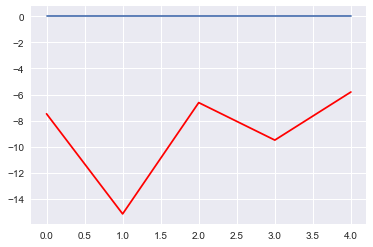

[ -5.80532344  -9.49165104  -6.61887633 -15.14801427  -7.47692812]
--------------------------------------------
predicted=29.269852, expected=0.000000
predicted=28.800954, expected=0.000000
predicted=29.309213, expected=0.000000
predicted=29.503770, expected=0.000000
predicted=30.184537, expected=0.000000
predicted=30.558551, expected=0.000000
length=3
num=6
i=5
Test MSE: 876.184
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


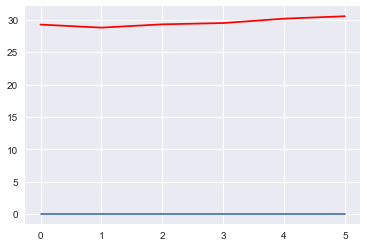

[ 30.54855143  30.174537    29.4937698   29.29921289  28.79095445
  29.25985222]
--------------------------------------------
predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
predicted=29.597794, expected=0.000000
predicted=29.866199, expected=0.000000
predicted=30.567502, expected=0.000000
predicted=30.986280, expected=0.000000
length=3
num=7
i=6
Test MSE: 768.147
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


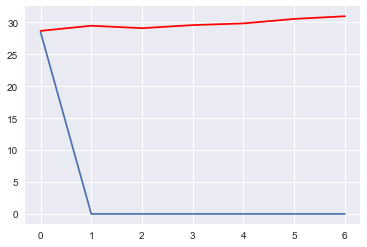

[ 30.9762797   30.55750243  29.85619913  29.58779404  29.10776487
  29.48924876  28.68291969]
--------------------------------------------
predicted=26.411311, expected=28.500000
predicted=26.059148, expected=28.500000
predicted=25.877167, expected=0.000000
predicted=25.848972, expected=0.000000
predicted=25.527884, expected=0.000000
predicted=25.588177, expected=0.000000
predicted=25.869663, expected=0.000000
predicted=25.934428, expected=0.000000
length=3
num=8
i=7
Test MSE: 499.172
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


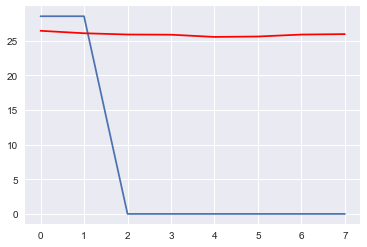

[ 25.92442844  25.85966312  25.57817723  25.517884    25.83897163
  25.8671667   26.04914847  26.40131115]
--------------------------------------------
predicted=25.397655, expected=26.500000
predicted=25.029551, expected=28.500000
predicted=24.181020, expected=28.500000
predicted=24.229873, expected=0.000000
predicted=23.817438, expected=0.000000
predicted=23.446833, expected=0.000000
predicted=23.365917, expected=0.000000
predicted=23.545110, expected=0.000000
predicted=23.412716, expected=0.000000
length=3
num=9
i=8
Test MSE: 375.762
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


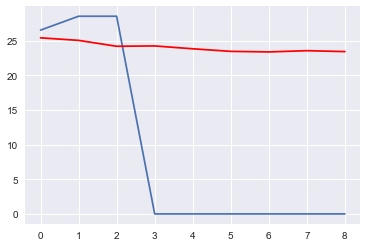

[ 23.40271579  23.53510967  23.35591727  23.43683276  23.80743798
  24.2198733   24.17102025  25.01955083  25.38765537]
--------------------------------------------
predicted=24.747792, expected=26.500000
predicted=23.242317, expected=26.500000
predicted=22.133070, expected=28.500000
predicted=21.689692, expected=28.500000
predicted=21.192883, expected=0.000000
predicted=20.798967, expected=0.000000
predicted=20.280576, expected=0.000000
predicted=20.111334, expected=0.000000
predicted=20.038373, expected=0.000000
predicted=19.786193, expected=0.000000
length=3
num=10
i=9
Test MSE: 258.905
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


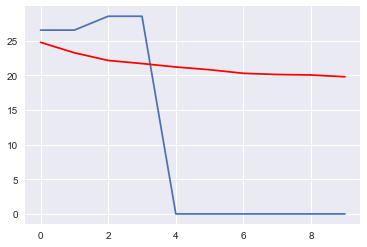

[ 19.77619292  20.02837341  20.10133441  20.2705762   20.78896672
  21.18288298  21.67969179  22.12307     23.23231683  24.73779237]
--------------------------------------------
predicted=21.589501, expected=24.000000
predicted=21.917495, expected=26.500000
predicted=19.463911, expected=26.500000
predicted=19.119178, expected=28.500000
predicted=18.091207, expected=28.500000
predicted=17.855185, expected=0.000000
predicted=17.361427, expected=0.000000
predicted=16.937678, expected=0.000000
predicted=16.582571, expected=0.000000
predicted=16.630553, expected=0.000000
predicted=16.580320, expected=0.000000
length=3
num=11
i=10
Test MSE: 182.261
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0. ]


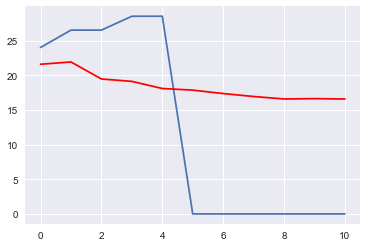

[ 16.57032024  16.62055261  16.57257064  16.92767772  17.35142748
  17.84518481  18.08120718  19.10917832  19.45391104  21.90749509
  21.57950141]
--------------------------------------------
predicted=20.561780, expected=24.000000
predicted=18.083195, expected=24.000000
predicted=17.240652, expected=26.500000
predicted=16.367527, expected=26.500000
predicted=15.165683, expected=28.500000
predicted=14.663800, expected=28.500000
predicted=14.026761, expected=0.000000
predicted=14.108905, expected=0.000000
predicted=13.333332, expected=0.000000
predicted=13.096630, expected=0.000000
predicted=12.705609, expected=0.000000
predicted=12.735043, expected=0.000000
length=3
num=12
i=11
Test MSE: 139.393
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0. 

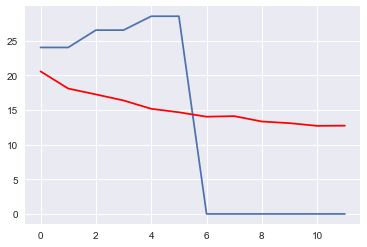

[ 12.72504276  12.69560894  13.0866303   13.32333223  14.09890532
  14.01676119  14.6538001   15.15568254  16.35752657  17.23065174
  18.07319537  20.55178041]
--------------------------------------------
predicted=20.390623, expected=21.000000
predicted=19.871436, expected=24.000000
predicted=17.262411, expected=24.000000
predicted=16.669775, expected=26.500000
predicted=15.725032, expected=26.500000
predicted=14.618108, expected=28.500000
predicted=14.156298, expected=28.500000
predicted=13.590735, expected=0.000000
predicted=13.704633, expected=0.000000
predicted=12.930157, expected=0.000000
predicted=12.789491, expected=0.000000
predicted=12.432529, expected=0.000000
predicted=12.537036, expected=0.000000
length=3
num=13
i=12
Test MSE: 129.898
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.  

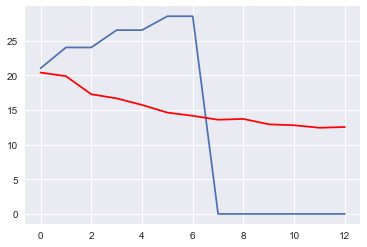

[ 12.52703586  12.42252858  12.77949057  12.92015678  13.69463286
  13.58073539  14.14629847  14.6081079   15.71503181  16.65977532
  17.25241074  19.86143601  20.3806234 ]
--------------------------------------------
predicted=15.230777, expected=21.000000
predicted=14.207415, expected=21.000000
predicted=12.668864, expected=24.000000
predicted=12.771142, expected=24.000000
predicted=11.759313, expected=26.500000
predicted=12.075906, expected=26.500000
predicted=11.672438, expected=28.500000
predicted=12.056021, expected=28.500000
predicted=12.080218, expected=0.000000
predicted=12.171392, expected=0.000000
predicted=12.384731, expected=0.000000
predicted=12.203427, expected=0.000000
predicted=12.413737, expected=0.000000
predicted=12.118918, expected=0.000000
length=3
num=14
i=13
Test MSE: 157.904
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   1

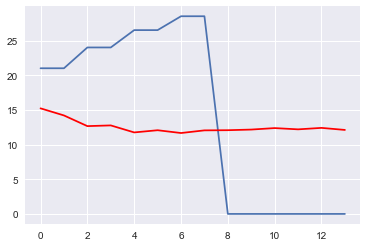

[ 12.10891807  12.40373713  12.19342746  12.37473132  12.16139209
  12.07021783  12.04602085  11.6624376   12.06590579  11.74931339
  12.76114181  12.65886366  14.19741472  15.22077693]
--------------------------------------------
predicted=15.678083, expected=16.500000
predicted=14.346772, expected=21.000000
predicted=13.240593, expected=21.000000
predicted=12.119577, expected=24.000000
predicted=12.220136, expected=24.000000
predicted=11.403072, expected=26.500000
predicted=11.859339, expected=26.500000
predicted=11.551231, expected=28.500000
predicted=12.085593, expected=28.500000
predicted=12.057614, expected=0.000000
predicted=12.256899, expected=0.000000
predicted=12.328933, expected=0.000000
predicted=12.189252, expected=0.000000
predicted=12.289295, expected=0.000000
predicted=12.015247, expected=0.000000
length=3
num=15
i=14
Test MSE: 151.746
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17

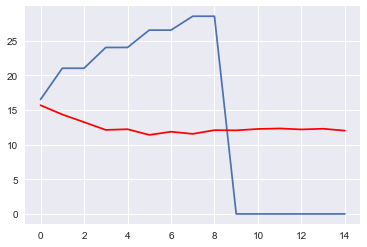

[ 12.00524659  12.27929527  12.17925199  12.31893294  12.24689948
  12.04761379  12.07559282  11.54123102  11.84933916  11.39307188
  12.21013565  12.10957684  13.23059315  14.33677204  15.6680833 ]
--------------------------------------------
predicted=-5.416732, expected=0.000000
predicted=-2.051214, expected=0.000000
predicted=3.093794, expected=0.000000
predicted=-0.303106, expected=0.000000
length=4
num=4
i=3
Test MSE: 10.826
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


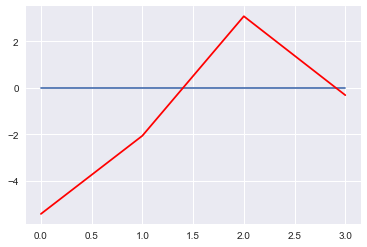

[-0.31310576  3.08379413 -2.06121414 -5.4267319 ]
--------------------------------------------
predicted=8.259066, expected=0.000000
predicted=1.918196, expected=0.000000
predicted=3.087066, expected=0.000000
predicted=7.837918, expected=0.000000
predicted=5.426398, expected=0.000000
length=4
num=5
i=4
Test MSE: 34.354
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


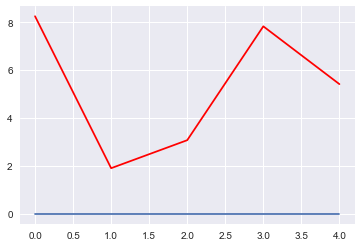

[ 5.4163978   7.82791759  3.07706643  1.90819643  8.24906595]
--------------------------------------------
predicted=-7.181528, expected=0.000000
predicted=1.900011, expected=0.000000
predicted=-3.935072, expected=0.000000
predicted=-0.530855, expected=0.000000
predicted=3.571561, expected=0.000000
predicted=1.891818, expected=0.000000
length=4
num=6
i=5
Test MSE: 14.562
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


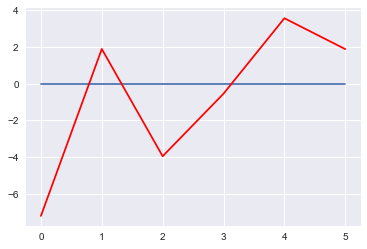

[ 1.88181838  3.5615613  -0.54085478 -3.94507248  1.89001053 -7.19152833]
--------------------------------------------
predicted=-7.466928, expected=0.000000
predicted=-15.138014, expected=0.000000
predicted=-6.608876, expected=0.000000
predicted=-9.481651, expected=0.000000
predicted=-5.795323, expected=0.000000
predicted=-0.064542, expected=0.000000
predicted=1.746522, expected=0.000000
length=4
num=7
i=6
Test MSE: 65.142
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


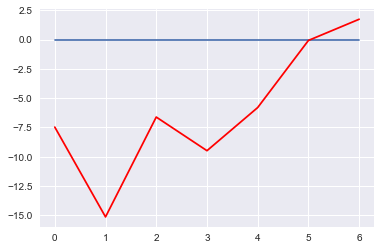

[  1.73652223  -0.07454202  -5.80532344  -9.49165104  -6.61887633
 -15.14801427  -7.47692812]
--------------------------------------------
predicted=29.269852, expected=0.000000
predicted=28.800954, expected=0.000000
predicted=29.309213, expected=0.000000
predicted=29.503770, expected=0.000000
predicted=30.184537, expected=0.000000
predicted=30.558551, expected=0.000000
predicted=31.285736, expected=0.000000
predicted=31.783009, expected=0.000000
length=4
num=8
i=7
Test MSE: 905.600
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


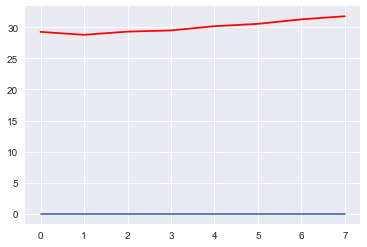

[ 31.77300859  31.27573555  30.54855143  30.174537    29.4937698
  29.29921289  28.79095445  29.25985222]
--------------------------------------------
predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
predicted=29.597794, expected=0.000000
predicted=29.866199, expected=0.000000
predicted=30.567502, expected=0.000000
predicted=30.986280, expected=0.000000
predicted=31.748908, expected=0.000000
predicted=32.301643, expected=0.000000
length=4
num=9
i=8
Test MSE: 825.238
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


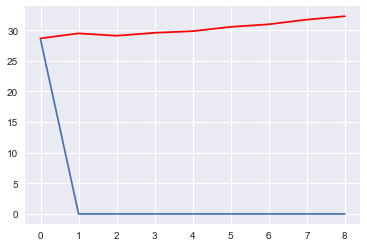

[ 32.29164325  31.73890803  30.9762797   30.55750243  29.85619913
  29.58779404  29.10776487  29.48924876  28.68291969]
--------------------------------------------
predicted=26.411311, expected=28.500000
predicted=26.059148, expected=28.500000
predicted=25.877167, expected=0.000000
predicted=25.848972, expected=0.000000
predicted=25.527884, expected=0.000000
predicted=25.588177, expected=0.000000
predicted=25.869663, expected=0.000000
predicted=25.934428, expected=0.000000
predicted=26.165668, expected=0.000000
predicted=26.282799, expected=0.000000
length=4
num=10
i=9
Test MSE: 536.776
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


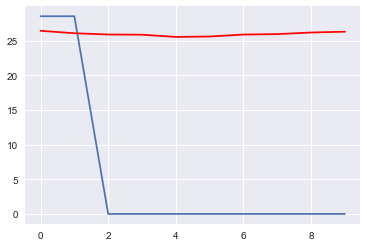

[ 26.27279897  26.15566837  25.92442844  25.85966312  25.57817723
  25.517884    25.83897163  25.8671667   26.04914847  26.40131115]
--------------------------------------------
predicted=25.397655, expected=26.500000
predicted=25.029551, expected=28.500000
predicted=24.181020, expected=28.500000
predicted=24.229873, expected=0.000000
predicted=23.817438, expected=0.000000
predicted=23.446833, expected=0.000000
predicted=23.365917, expected=0.000000
predicted=23.545110, expected=0.000000
predicted=23.412716, expected=0.000000
predicted=23.501161, expected=0.000000
predicted=23.592177, expected=0.000000
length=4
num=11
i=10
Test MSE: 408.165
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0. ]


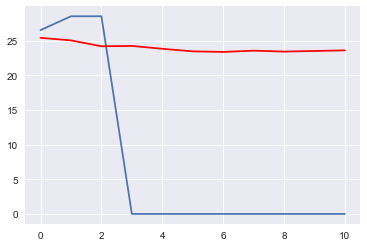

[ 23.58217714  23.49116136  23.40271579  23.53510967  23.35591727
  23.43683276  23.80743798  24.2198733   24.17102025  25.01955083
  25.38765537]
--------------------------------------------
predicted=24.747792, expected=26.500000
predicted=23.242317, expected=26.500000
predicted=22.133070, expected=28.500000
predicted=21.689692, expected=28.500000
predicted=21.192883, expected=0.000000
predicted=20.798967, expected=0.000000
predicted=20.280576, expected=0.000000
predicted=20.111334, expected=0.000000
predicted=20.038373, expected=0.000000
predicted=19.786193, expected=0.000000
predicted=19.905260, expected=0.000000
predicted=19.950911, expected=0.000000
length=4
num=12
i=11
Test MSE: 281.876
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.   

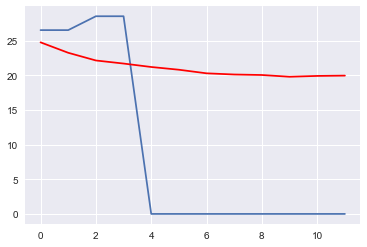

[ 19.9409113   19.89526031  19.77619292  20.02837341  20.10133441
  20.2705762   20.78896672  21.18288298  21.67969179  22.12307     23.23231683
  24.73779237]
--------------------------------------------
predicted=21.589501, expected=24.000000
predicted=21.917495, expected=26.500000
predicted=19.463911, expected=26.500000
predicted=19.119178, expected=28.500000
predicted=18.091207, expected=28.500000
predicted=17.855185, expected=0.000000
predicted=17.361427, expected=0.000000
predicted=16.937678, expected=0.000000
predicted=16.582571, expected=0.000000
predicted=16.630553, expected=0.000000
predicted=16.580320, expected=0.000000
predicted=16.904182, expected=0.000000
predicted=16.820331, expected=0.000000
length=4
num=13
i=12
Test MSE: 197.913
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   2

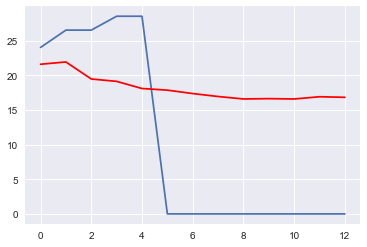

[ 16.81033136  16.89418167  16.57032024  16.62055261  16.57257064
  16.92767772  17.35142748  17.84518481  18.08120718  19.10917832
  19.45391104  21.90749509  21.57950141]
--------------------------------------------
predicted=20.561780, expected=24.000000
predicted=18.083195, expected=24.000000
predicted=17.240652, expected=26.500000
predicted=16.367527, expected=26.500000
predicted=15.165683, expected=28.500000
predicted=14.663800, expected=28.500000
predicted=14.026761, expected=0.000000
predicted=14.108905, expected=0.000000
predicted=13.333332, expected=0.000000
predicted=13.096630, expected=0.000000
predicted=12.705609, expected=0.000000
predicted=12.735043, expected=0.000000
predicted=12.635096, expected=0.000000
predicted=12.591347, expected=0.000000
length=4
num=14
i=13
Test MSE: 142.172
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.

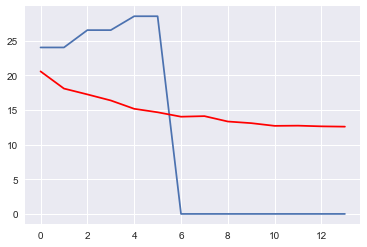

[ 12.58134688  12.6250958   12.72504276  12.69560894  13.0866303
  13.32333223  14.09890532  14.01676119  14.6538001   15.15568254
  16.35752657  17.23065174  18.07319537  20.55178041]
--------------------------------------------
predicted=20.390623, expected=21.000000
predicted=19.871436, expected=24.000000
predicted=17.262411, expected=24.000000
predicted=16.669775, expected=26.500000
predicted=15.725032, expected=26.500000
predicted=14.618108, expected=28.500000
predicted=14.156298, expected=28.500000
predicted=13.590735, expected=0.000000
predicted=13.704633, expected=0.000000
predicted=12.930157, expected=0.000000
predicted=12.789491, expected=0.000000
predicted=12.432529, expected=0.000000
predicted=12.537036, expected=0.000000
predicted=12.435489, expected=0.000000
predicted=12.440414, expected=0.000000
length=4
num=15
i=14
Test MSE: 133.172
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.  

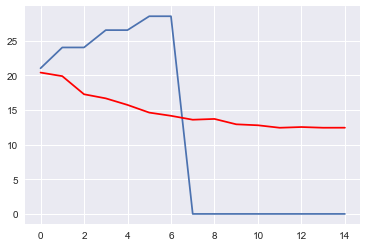

[ 12.43041448  12.42548897  12.52703586  12.42252858  12.77949057
  12.92015678  13.69463286  13.58073539  14.14629847  14.6081079
  15.71503181  16.65977532  17.25241074  19.86143601  20.3806234 ]
--------------------------------------------
predicted=2.570562, expected=0.000000
predicted=6.347611, expected=0.000000
predicted=3.529466, expected=0.000000
predicted=12.398136, expected=0.000000
predicted=13.083916, expected=0.000000
length=5
num=5
i=4
Test MSE: 76.700
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]


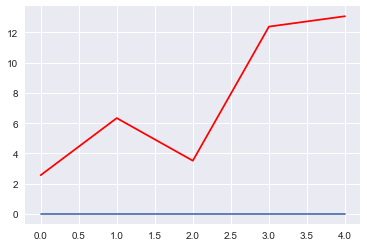

[ 13.07391554  12.3881358    3.51946576   6.33761103   2.56056162]
--------------------------------------------
predicted=-5.416732, expected=0.000000
predicted=-2.051214, expected=0.000000
predicted=3.093794, expected=0.000000
predicted=-0.303106, expected=0.000000
predicted=8.842495, expected=0.000000
predicted=11.030235, expected=0.000000
length=5
num=6
i=5
Test MSE: 40.461
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]


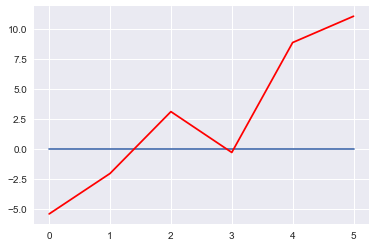

[ 11.02023456   8.83249482  -0.31310576   3.08379413  -2.06121414
  -5.4267319 ]
--------------------------------------------
predicted=8.259066, expected=0.000000
predicted=1.918196, expected=0.000000
predicted=3.087066, expected=0.000000
predicted=7.837918, expected=0.000000
predicted=5.426398, expected=0.000000
predicted=12.992176, expected=0.000000
predicted=11.659491, expected=0.000000
length=5
num=7
i=6
Test MSE: 68.003
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]


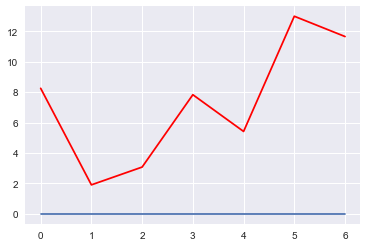

[ 11.64949084  12.98217647   5.4163978    7.82791759   3.07706643
   1.90819643   8.24906595]
--------------------------------------------
predicted=-7.181528, expected=0.000000
predicted=1.900011, expected=0.000000
predicted=-3.935072, expected=0.000000
predicted=-0.530855, expected=0.000000
predicted=3.571561, expected=0.000000
predicted=1.891818, expected=0.000000
predicted=12.509307, expected=0.000000
predicted=9.856207, expected=0.000000
length=5
num=8
i=7
Test MSE: 42.569
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]


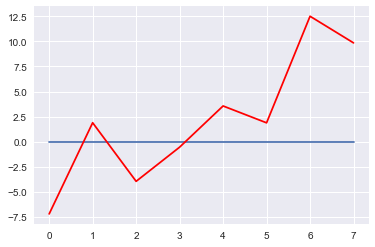

[  9.84620732  12.49930725   1.88181838   3.5615613   -0.54085478
  -3.94507248   1.89001053  -7.19152833]
--------------------------------------------
predicted=-7.466928, expected=0.000000
predicted=-15.138014, expected=0.000000
predicted=-6.608876, expected=0.000000
predicted=-9.481651, expected=0.000000
predicted=-5.795323, expected=0.000000
predicted=-0.064542, expected=0.000000
predicted=1.746522, expected=0.000000
predicted=12.242834, expected=0.000000
predicted=15.424571, expected=0.000000
length=5
num=9
i=8
Test MSE: 93.694
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]


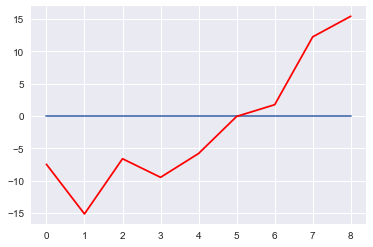

[ 15.41457148  12.23283355   1.73652223  -0.07454202  -5.80532344
  -9.49165104  -6.61887633 -15.14801427  -7.47692812]
--------------------------------------------
predicted=29.269852, expected=0.000000
predicted=28.800954, expected=0.000000
predicted=29.309213, expected=0.000000
predicted=29.503770, expected=0.000000
predicted=30.184537, expected=0.000000
predicted=30.558551, expected=0.000000
predicted=31.285736, expected=0.000000
predicted=31.783009, expected=0.000000
predicted=32.472799, expected=0.000000
predicted=32.980762, expected=0.000000
length=5
num=10
i=9
Test MSE: 938.570
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]


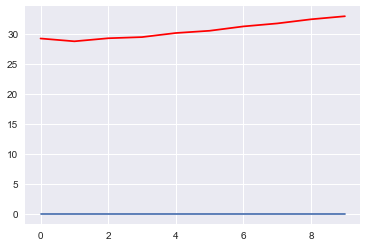

[ 32.97076245  32.46279877  31.77300859  31.27573555  30.54855143
  30.174537    29.4937698   29.29921289  28.79095445  29.25985222]
--------------------------------------------
predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
predicted=29.597794, expected=0.000000
predicted=29.866199, expected=0.000000
predicted=30.567502, expected=0.000000
predicted=30.986280, expected=0.000000
predicted=31.748908, expected=0.000000
predicted=32.301643, expected=0.000000
predicted=33.033324, expected=0.000000
predicted=33.576167, expected=0.000000
length=5
num=11
i=10
Test MSE: 876.761
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0. ]


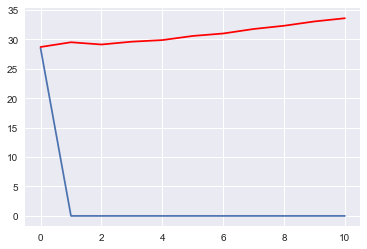

[ 33.56616687  33.02332404  32.29164325  31.73890803  30.9762797
  30.55750243  29.85619913  29.58779404  29.10776487  29.48924876
  28.68291969]
--------------------------------------------
predicted=26.411311, expected=28.500000
predicted=26.059148, expected=28.500000
predicted=25.877167, expected=0.000000
predicted=25.848972, expected=0.000000
predicted=25.527884, expected=0.000000
predicted=25.588177, expected=0.000000
predicted=25.869663, expected=0.000000
predicted=25.934428, expected=0.000000
predicted=26.165668, expected=0.000000
predicted=26.282799, expected=0.000000
predicted=26.744224, expected=0.000000
predicted=26.917271, expected=0.000000
length=5
num=12
i=11
Test MSE: 567.206
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.

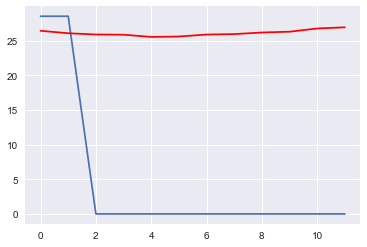

[ 26.90727148  26.734224    26.27279897  26.15566837  25.92442844
  25.85966312  25.57817723  25.517884    25.83897163  25.8671667
  26.04914847  26.40131115]
--------------------------------------------
predicted=25.397655, expected=26.500000
predicted=25.029551, expected=28.500000
predicted=24.181020, expected=28.500000
predicted=24.229873, expected=0.000000
predicted=23.817438, expected=0.000000
predicted=23.446833, expected=0.000000
predicted=23.365917, expected=0.000000
predicted=23.545110, expected=0.000000
predicted=23.412716, expected=0.000000
predicted=23.501161, expected=0.000000
predicted=23.592177, expected=0.000000
predicted=23.975192, expected=0.000000
predicted=23.970028, expected=0.000000
length=5
num=13
i=12
Test MSE: 433.710
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24. 

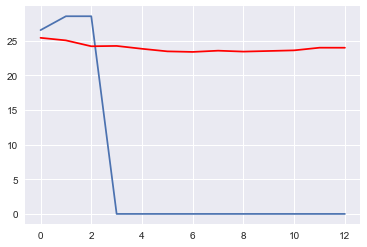

[ 23.96002845  23.96519233  23.58217714  23.49116136  23.40271579
  23.53510967  23.35591727  23.43683276  23.80743798  24.2198733
  24.17102025  25.01955083  25.38765537]
--------------------------------------------
predicted=24.747792, expected=26.500000
predicted=23.242317, expected=26.500000
predicted=22.133070, expected=28.500000
predicted=21.689692, expected=28.500000
predicted=21.192883, expected=0.000000
predicted=20.798967, expected=0.000000
predicted=20.280576, expected=0.000000
predicted=20.111334, expected=0.000000
predicted=20.038373, expected=0.000000
predicted=19.786193, expected=0.000000
predicted=19.905260, expected=0.000000
predicted=19.950911, expected=0.000000
predicted=20.127393, expected=0.000000
predicted=20.004730, expected=0.000000
length=5
num=14
i=13
Test MSE: 299.072
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  

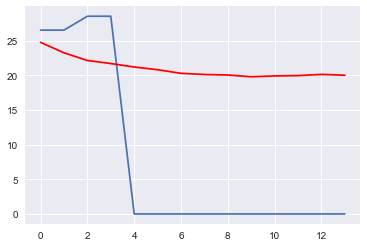

[ 19.99472986  20.11739296  19.9409113   19.89526031  19.77619292
  20.02837341  20.10133441  20.2705762   20.78896672  21.18288298
  21.67969179  22.12307     23.23231683  24.73779237]
--------------------------------------------
predicted=21.589501, expected=24.000000
predicted=21.917495, expected=26.500000
predicted=19.463911, expected=26.500000
predicted=19.119178, expected=28.500000
predicted=18.091207, expected=28.500000
predicted=17.855185, expected=0.000000
predicted=17.361427, expected=0.000000
predicted=16.937678, expected=0.000000
predicted=16.582571, expected=0.000000
predicted=16.630553, expected=0.000000
predicted=16.580320, expected=0.000000
predicted=16.904182, expected=0.000000
predicted=16.820331, expected=0.000000
predicted=17.028976, expected=0.000000
predicted=16.828071, expected=0.000000
length=5
num=15
i=14
Test MSE: 209.691
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   

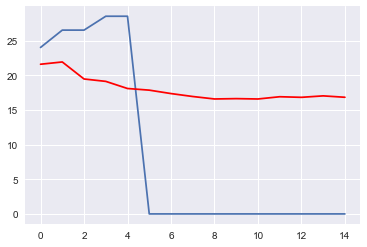

[ 16.81807053  17.0189758   16.81033136  16.89418167  16.57032024
  16.62055261  16.57257064  16.92767772  17.35142748  17.84518481
  18.08120718  19.10917832  19.45391104  21.90749509  21.57950141]
--------------------------------------------
predicted=4.187827, expected=0.000000
predicted=2.041915, expected=0.000000
predicted=10.598316, expected=0.000000
predicted=11.783707, expected=0.000000
predicted=15.007108, expected=0.000000
predicted=16.845012, expected=0.000000
length=6
num=6
i=5
Test MSE: 130.108
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0. ]


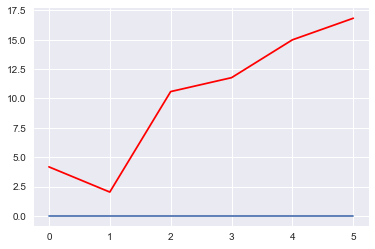

[ 16.83501185  14.99710766  11.77370677  10.58831587   2.03191476
   4.17782709]
--------------------------------------------
predicted=2.570562, expected=0.000000
predicted=6.347611, expected=0.000000
predicted=3.529466, expected=0.000000
predicted=12.398136, expected=0.000000
predicted=13.083916, expected=0.000000
predicted=15.750804, expected=0.000000
predicted=16.668269, expected=0.000000
length=6
num=7
i=6
Test MSE: 129.825
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0. ]


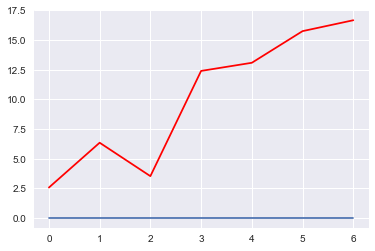

[ 16.65826925  15.74080445  13.07391554  12.3881358    3.51946576
   6.33761103   2.56056162]
--------------------------------------------
predicted=-5.416732, expected=0.000000
predicted=-2.051214, expected=0.000000
predicted=3.093794, expected=0.000000
predicted=-0.303106, expected=0.000000
predicted=8.842495, expected=0.000000
predicted=11.030235, expected=0.000000
predicted=16.015930, expected=0.000000
predicted=15.724209, expected=0.000000
length=6
num=8
i=7
Test MSE: 93.236
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0. ]


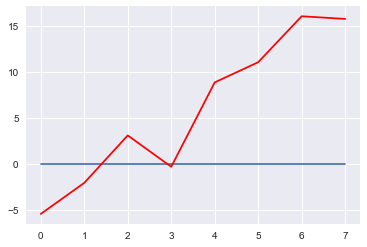

[ 15.71420878  16.00593046  11.02023456   8.83249482  -0.31310576
   3.08379413  -2.06121414  -5.4267319 ]
--------------------------------------------
predicted=8.259066, expected=0.000000
predicted=1.918196, expected=0.000000
predicted=3.087066, expected=0.000000
predicted=7.837918, expected=0.000000
predicted=5.426398, expected=0.000000
predicted=12.992176, expected=0.000000
predicted=11.659491, expected=0.000000
predicted=18.678202, expected=0.000000
predicted=13.540872, expected=0.000000
length=6
num=9
i=8
Test MSE: 111.956
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0. ]


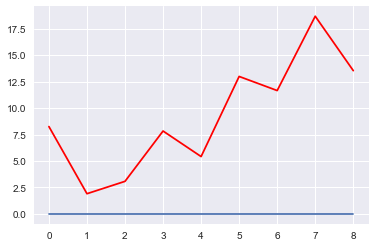

[ 13.53087152  18.66820154  11.64949084  12.98217647   5.4163978
   7.82791759   3.07706643   1.90819643   8.24906595]
--------------------------------------------
predicted=-7.181528, expected=0.000000
predicted=1.900011, expected=0.000000
predicted=-3.935072, expected=0.000000
predicted=-0.530855, expected=0.000000
predicted=3.571561, expected=0.000000
predicted=1.891818, expected=0.000000
predicted=12.509307, expected=0.000000
predicted=9.856207, expected=0.000000
predicted=21.638620, expected=0.000000
predicted=15.962084, expected=0.000000
length=6
num=10
i=9
Test MSE: 106.282
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0. ]


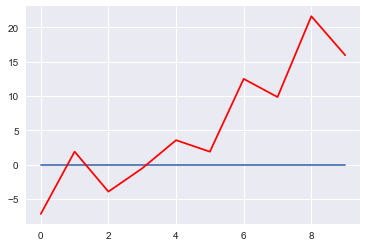

[ 15.95208394  21.6286204    9.84620732  12.49930725   1.88181838
   3.5615613   -0.54085478  -3.94507248   1.89001053  -7.19152833]
--------------------------------------------
predicted=-7.466928, expected=0.000000
predicted=-15.138014, expected=0.000000
predicted=-6.608876, expected=0.000000
predicted=-9.481651, expected=0.000000
predicted=-5.795323, expected=0.000000
predicted=-0.064542, expected=0.000000
predicted=1.746522, expected=0.000000
predicted=12.242834, expected=0.000000
predicted=15.424571, expected=0.000000
predicted=27.757904, expected=0.000000
predicted=26.641693, expected=0.000000
length=6
num=11
i=10
Test MSE: 211.130
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0. ]


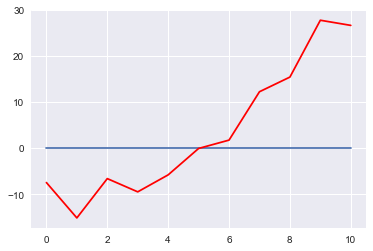

[ 26.63169254  27.74790437  15.41457148  12.23283355   1.73652223
  -0.07454202  -5.80532344  -9.49165104  -6.61887633 -15.14801427
  -7.47692812]
--------------------------------------------
predicted=29.269852, expected=0.000000
predicted=28.800954, expected=0.000000
predicted=29.309213, expected=0.000000
predicted=29.503770, expected=0.000000
predicted=30.184537, expected=0.000000
predicted=30.558551, expected=0.000000
predicted=31.285736, expected=0.000000
predicted=31.783009, expected=0.000000
predicted=32.472799, expected=0.000000
predicted=32.980762, expected=0.000000
predicted=33.730655, expected=0.000000
predicted=34.317989, expected=0.000000
length=6
num=12
i=11
Test MSE: 974.985
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0. 

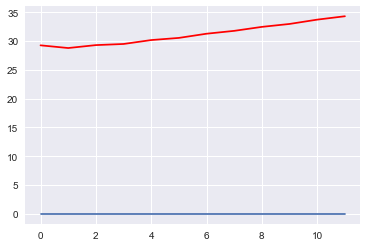

[ 34.30798943  33.72065464  32.97076245  32.46279877  31.77300859
  31.27573555  30.54855143  30.174537    29.4937698   29.29921289
  28.79095445  29.25985222]
--------------------------------------------
predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
predicted=29.597794, expected=0.000000
predicted=29.866199, expected=0.000000
predicted=30.567502, expected=0.000000
predicted=30.986280, expected=0.000000
predicted=31.748908, expected=0.000000
predicted=32.301643, expected=0.000000
predicted=33.033324, expected=0.000000
predicted=33.576167, expected=0.000000
predicted=34.366954, expected=0.000000
predicted=35.015617, expected=0.000000
length=6
num=13
i=12
Test MSE: 926.936
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.  

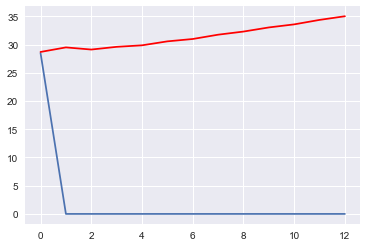

[ 35.00561744  34.35695442  33.56616687  33.02332404  32.29164325
  31.73890803  30.9762797   30.55750243  29.85619913  29.58779404
  29.10776487  29.48924876  28.68291969]
--------------------------------------------
predicted=26.411311, expected=28.500000
predicted=26.059148, expected=28.500000
predicted=25.877167, expected=0.000000
predicted=25.848972, expected=0.000000
predicted=25.527884, expected=0.000000
predicted=25.588177, expected=0.000000
predicted=25.869663, expected=0.000000
predicted=25.934428, expected=0.000000
predicted=26.165668, expected=0.000000
predicted=26.282799, expected=0.000000
predicted=26.744224, expected=0.000000
predicted=26.917271, expected=0.000000
predicted=27.144161, expected=0.000000
predicted=27.309119, expected=0.000000
length=6
num=14
i=13
Test MSE: 591.999
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  1

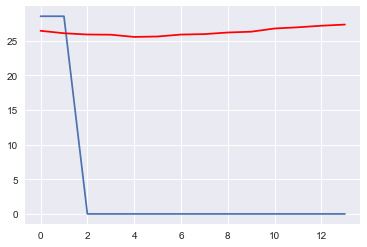

[ 27.29911943  27.13416078  26.90727148  26.734224    26.27279897
  26.15566837  25.92442844  25.85966312  25.57817723  25.517884
  25.83897163  25.8671667   26.04914847  26.40131115]
--------------------------------------------
predicted=25.397655, expected=26.500000
predicted=25.029551, expected=28.500000
predicted=24.181020, expected=28.500000
predicted=24.229873, expected=0.000000
predicted=23.817438, expected=0.000000
predicted=23.446833, expected=0.000000
predicted=23.365917, expected=0.000000
predicted=23.545110, expected=0.000000
predicted=23.412716, expected=0.000000
predicted=23.501161, expected=0.000000
predicted=23.592177, expected=0.000000
predicted=23.975192, expected=0.000000
predicted=23.970028, expected=0.000000
predicted=24.058491, expected=0.000000
predicted=24.085190, expected=0.000000
length=6
num=15
i=14
Test MSE: 453.078
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.


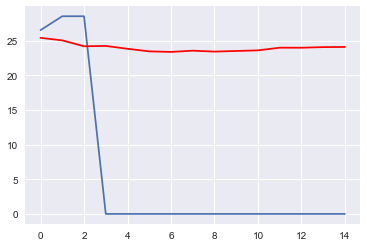

[ 24.0751905   24.04849087  23.96002845  23.96519233  23.58217714
  23.49116136  23.40271579  23.53510967  23.35591727  23.43683276
  23.80743798  24.2198733   24.17102025  25.01955083  25.38765537]
--------------------------------------------
predicted=-1.594458, expected=0.000000
predicted=8.120203, expected=0.000000
predicted=8.788519, expected=0.000000
predicted=12.630579, expected=0.000000
predicted=15.176679, expected=0.000000
predicted=17.554037, expected=0.000000
predicted=19.113633, expected=0.000000
length=7
num=7
i=6
Test MSE: 172.494
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]


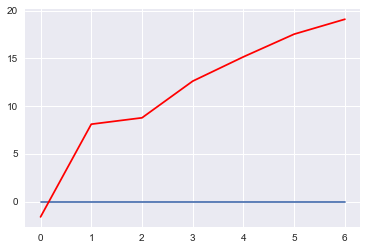

[ 19.10363308  17.54403695  15.1666794   12.62057931   8.77851898
   8.11020289  -1.60445799]
--------------------------------------------
predicted=4.187827, expected=0.000000
predicted=2.041915, expected=0.000000
predicted=10.598316, expected=0.000000
predicted=11.783707, expected=0.000000
predicted=15.007108, expected=0.000000
predicted=16.845012, expected=0.000000
predicted=18.011596, expected=0.000000
predicted=19.798699, expected=0.000000
length=7
num=8
i=7
Test MSE: 187.037
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]


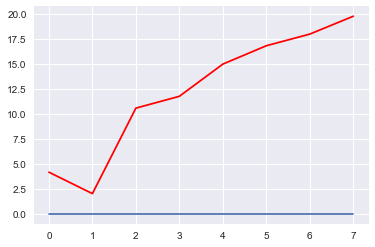

[ 19.78869942  18.0015964   16.83501185  14.99710766  11.77370677
  10.58831587   2.03191476   4.17782709]
--------------------------------------------
predicted=2.570562, expected=0.000000
predicted=6.347611, expected=0.000000
predicted=3.529466, expected=0.000000
predicted=12.398136, expected=0.000000
predicted=13.083916, expected=0.000000
predicted=15.750804, expected=0.000000
predicted=16.668269, expected=0.000000
predicted=18.216587, expected=0.000000
predicted=18.599171, expected=0.000000
length=7
num=9
i=8
Test MSE: 176.201
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]


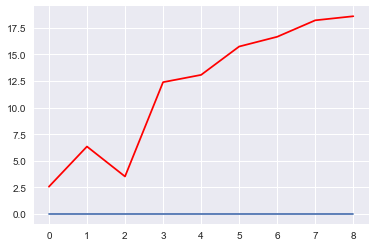

[ 18.58917093  18.20658687  16.65826925  15.74080445  13.07391554
  12.3881358    3.51946576   6.33761103   2.56056162]
--------------------------------------------
predicted=-5.416732, expected=0.000000
predicted=-2.051214, expected=0.000000
predicted=3.093794, expected=0.000000
predicted=-0.303106, expected=0.000000
predicted=8.842495, expected=0.000000
predicted=11.030235, expected=0.000000
predicted=16.015930, expected=0.000000
predicted=15.724209, expected=0.000000
predicted=20.670772, expected=0.000000
predicted=21.725957, expected=0.000000
length=7
num=10
i=9
Test MSE: 164.434
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]


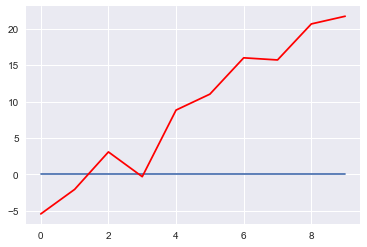

[ 21.71595721  20.66077185  15.71420878  16.00593046  11.02023456
   8.83249482  -0.31310576   3.08379413  -2.06121414  -5.4267319 ]
--------------------------------------------
predicted=8.259066, expected=0.000000
predicted=1.918196, expected=0.000000
predicted=3.087066, expected=0.000000
predicted=7.837918, expected=0.000000
predicted=5.426398, expected=0.000000
predicted=12.992176, expected=0.000000
predicted=11.659491, expected=0.000000
predicted=18.678202, expected=0.000000
predicted=13.540872, expected=0.000000
predicted=17.129762, expected=0.000000
predicted=16.706797, expected=0.000000
length=7
num=11
i=10
Test MSE: 143.588
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]


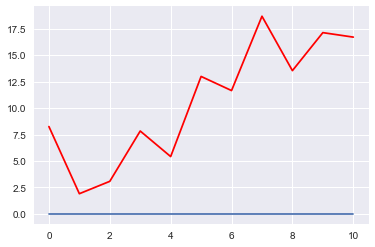

[ 16.69679738  17.11976223  13.53087152  18.66820154  11.64949084
  12.98217647   5.4163978    7.82791759   3.07706643   1.90819643
   8.24906595]
--------------------------------------------
predicted=-7.181528, expected=0.000000
predicted=1.900011, expected=0.000000
predicted=-3.935072, expected=0.000000
predicted=-0.530855, expected=0.000000
predicted=3.571561, expected=0.000000
predicted=1.891818, expected=0.000000
predicted=12.509307, expected=0.000000
predicted=9.856207, expected=0.000000
predicted=21.638620, expected=0.000000
predicted=15.962084, expected=0.000000
predicted=22.796634, expected=0.000000
predicted=19.887196, expected=0.000000
length=7
num=12
i=11
Test MSE: 164.763
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0

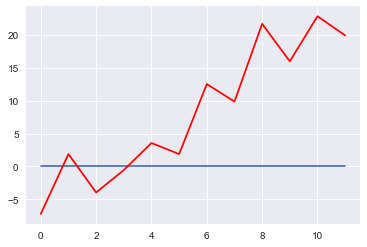

[ 19.87719593  22.78663443  15.95208394  21.6286204    9.84620732
  12.49930725   1.88181838   3.5615613   -0.54085478  -3.94507248
   1.89001053  -7.19152833]
--------------------------------------------
predicted=-7.466928, expected=0.000000
predicted=-15.138014, expected=0.000000
predicted=-6.608876, expected=0.000000
predicted=-9.481651, expected=0.000000
predicted=-5.795323, expected=0.000000
predicted=-0.064542, expected=0.000000
predicted=1.746522, expected=0.000000
predicted=12.242834, expected=0.000000
predicted=15.424571, expected=0.000000
predicted=27.757904, expected=0.000000
predicted=26.641693, expected=0.000000
predicted=30.850061, expected=0.000000
predicted=28.221253, expected=0.000000
length=7
num=13
i=12
Test MSE: 313.032
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   

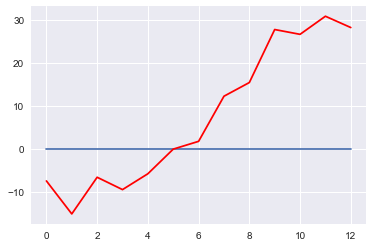

[ 28.21125269  30.8400611   26.63169254  27.74790437  15.41457148
  12.23283355   1.73652223  -0.07454202  -5.80532344  -9.49165104
  -6.61887633 -15.14801427  -7.47692812]
--------------------------------------------
predicted=29.269852, expected=0.000000
predicted=28.800954, expected=0.000000
predicted=29.309213, expected=0.000000
predicted=29.503770, expected=0.000000
predicted=30.184537, expected=0.000000
predicted=30.558551, expected=0.000000
predicted=31.285736, expected=0.000000
predicted=31.783009, expected=0.000000
predicted=32.472799, expected=0.000000
predicted=32.980762, expected=0.000000
predicted=33.730655, expected=0.000000
predicted=34.317989, expected=0.000000
predicted=34.974623, expected=0.000000
predicted=35.487646, expected=0.000000
length=7
num=14
i=13
Test MSE: 1012.929
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12

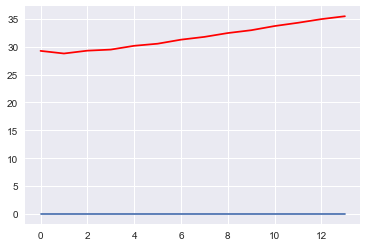

[ 35.47764584  34.96462271  34.30798943  33.72065464  32.97076245
  32.46279877  31.77300859  31.27573555  30.54855143  30.174537    29.4937698
  29.29921289  28.79095445  29.25985222]
--------------------------------------------
predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
predicted=29.597794, expected=0.000000
predicted=29.866199, expected=0.000000
predicted=30.567502, expected=0.000000
predicted=30.986280, expected=0.000000
predicted=31.748908, expected=0.000000
predicted=32.301643, expected=0.000000
predicted=33.033324, expected=0.000000
predicted=33.576167, expected=0.000000
predicted=34.366954, expected=0.000000
predicted=35.015617, expected=0.000000
predicted=35.724583, expected=0.000000
predicted=36.294974, expected=0.000000
length=7
num=15
i=14
Test MSE: 976.153
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
 

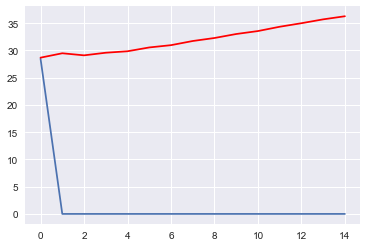

[ 36.28497378  35.71458271  35.00561744  34.35695442  33.56616687
  33.02332404  32.29164325  31.73890803  30.9762797   30.55750243
  29.85619913  29.58779404  29.10776487  29.48924876  28.68291969]
--------------------------------------------
predicted=9.616337, expected=0.000000
predicted=9.771278, expected=0.000000
predicted=13.317357, expected=0.000000
predicted=15.686143, expected=0.000000
predicted=17.889999, expected=0.000000
predicted=19.269459, expected=0.000000
predicted=19.843510, expected=0.000000
predicted=20.738157, expected=0.000000
length=8
num=8
i=7
Test MSE: 265.505
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0. ]


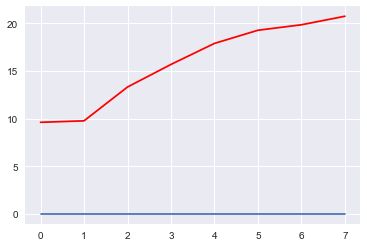

[ 20.7281568   19.83350987  19.25945885  17.87999877  15.67614328
  13.30735674   9.76127827   9.60633748]
--------------------------------------------
predicted=-1.594458, expected=0.000000
predicted=8.120203, expected=0.000000
predicted=8.788519, expected=0.000000
predicted=12.630579, expected=0.000000
predicted=15.176679, expected=0.000000
predicted=17.554037, expected=0.000000
predicted=19.113633, expected=0.000000
predicted=19.651858, expected=0.000000
predicted=21.514734, expected=0.000000
length=8
num=9
i=8
Test MSE: 228.413
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0. ]


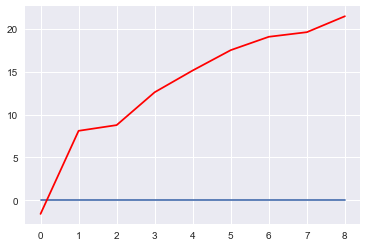

[ 21.50473362  19.64185839  19.10363308  17.54403695  15.1666794
  12.62057931   8.77851898   8.11020289  -1.60445799]
--------------------------------------------
predicted=4.187827, expected=0.000000
predicted=2.041915, expected=0.000000
predicted=10.598316, expected=0.000000
predicted=11.783707, expected=0.000000
predicted=15.007108, expected=0.000000
predicted=16.845012, expected=0.000000
predicted=18.011596, expected=0.000000
predicted=19.798699, expected=0.000000
predicted=17.868109, expected=0.000000
predicted=19.392968, expected=0.000000
length=8
num=10
i=9
Test MSE: 219.091
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0. ]


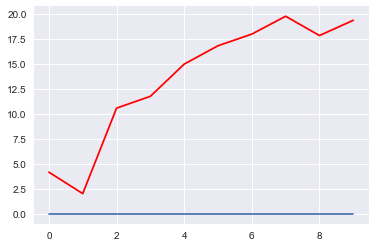

[ 19.38296805  17.85810902  19.78869942  18.0015964   16.83501185
  14.99710766  11.77370677  10.58831587   2.03191476   4.17782709]
--------------------------------------------
predicted=2.570562, expected=0.000000
predicted=6.347611, expected=0.000000
predicted=3.529466, expected=0.000000
predicted=12.398136, expected=0.000000
predicted=13.083916, expected=0.000000
predicted=15.750804, expected=0.000000
predicted=16.668269, expected=0.000000
predicted=18.216587, expected=0.000000
predicted=18.599171, expected=0.000000
predicted=16.478082, expected=0.000000
predicted=18.147297, expected=0.000000
length=8
num=11
i=10
Test MSE: 198.724
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   

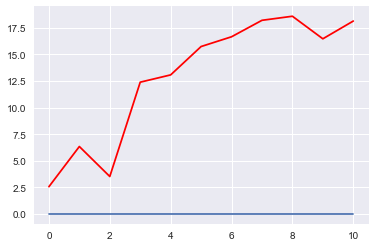

[ 18.13729721  16.46808205  18.58917093  18.20658687  16.65826925
  15.74080445  13.07391554  12.3881358    3.51946576   6.33761103
   2.56056162]
--------------------------------------------
predicted=-5.416732, expected=0.000000
predicted=-2.051214, expected=0.000000
predicted=3.093794, expected=0.000000
predicted=-0.303106, expected=0.000000
predicted=8.842495, expected=0.000000
predicted=11.030235, expected=0.000000
predicted=16.015930, expected=0.000000
predicted=15.724209, expected=0.000000
predicted=20.670772, expected=0.000000
predicted=21.725957, expected=0.000000
predicted=19.673338, expected=0.000000
predicted=21.458286, expected=0.000000
length=8
num=12
i=11
Test MSE: 207.585
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.   

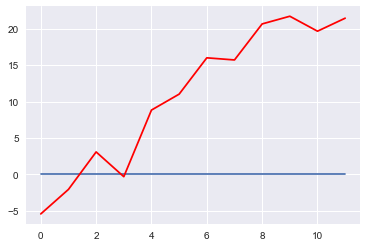

[ 21.44828569  19.66333833  21.71595721  20.66077185  15.71420878
  16.00593046  11.02023456   8.83249482  -0.31310576   3.08379413
  -2.06121414  -5.4267319 ]
--------------------------------------------
predicted=8.259066, expected=0.000000
predicted=1.918196, expected=0.000000
predicted=3.087066, expected=0.000000
predicted=7.837918, expected=0.000000
predicted=5.426398, expected=0.000000
predicted=12.992176, expected=0.000000
predicted=11.659491, expected=0.000000
predicted=18.678202, expected=0.000000
predicted=13.540872, expected=0.000000
predicted=17.129762, expected=0.000000
predicted=16.706797, expected=0.000000
predicted=16.001499, expected=0.000000
predicted=16.674902, expected=0.000000
length=8
num=13
i=12
Test MSE: 162.532
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5 

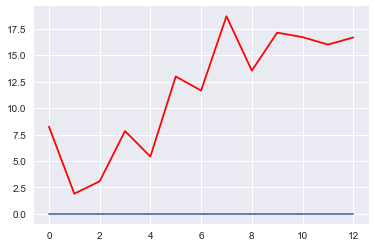

[ 16.66490168  15.99149872  16.69679738  17.11976223  13.53087152
  18.66820154  11.64949084  12.98217647   5.4163978    7.82791759
   3.07706643   1.90819643   8.24906595]
--------------------------------------------
predicted=-7.181528, expected=0.000000
predicted=1.900011, expected=0.000000
predicted=-3.935072, expected=0.000000
predicted=-0.530855, expected=0.000000
predicted=3.571561, expected=0.000000
predicted=1.891818, expected=0.000000
predicted=12.509307, expected=0.000000
predicted=9.856207, expected=0.000000
predicted=21.638620, expected=0.000000
predicted=15.962084, expected=0.000000
predicted=22.796634, expected=0.000000
predicted=19.887196, expected=0.000000
predicted=20.020265, expected=0.000000
predicted=20.462159, expected=0.000000
length=8
num=14
i=13
Test MSE: 199.704
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  1

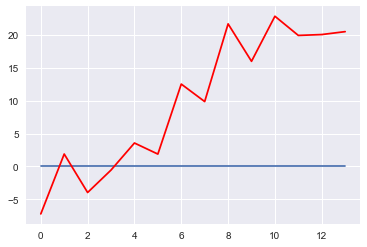

[ 20.45215898  20.01026478  19.87719593  22.78663443  15.95208394
  21.6286204    9.84620732  12.49930725   1.88181838   3.5615613
  -0.54085478  -3.94507248   1.89001053  -7.19152833]
--------------------------------------------
predicted=-7.466928, expected=0.000000
predicted=-15.138014, expected=0.000000
predicted=-6.608876, expected=0.000000
predicted=-9.481651, expected=0.000000
predicted=-5.795323, expected=0.000000
predicted=-0.064542, expected=0.000000
predicted=1.746522, expected=0.000000
predicted=12.242834, expected=0.000000
predicted=15.424571, expected=0.000000
predicted=27.757904, expected=0.000000
predicted=26.641693, expected=0.000000
predicted=30.850061, expected=0.000000
predicted=28.221253, expected=0.000000
predicted=26.278585, expected=0.000000
predicted=23.266607, expected=0.000000
length=8
num=15
i=14
Test MSE: 353.355
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  

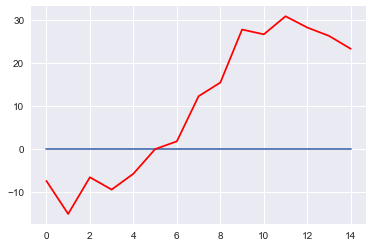

[ 23.25660747  26.26858536  28.21125269  30.8400611   26.63169254
  27.74790437  15.41457148  12.23283355   1.73652223  -0.07454202
  -5.80532344  -9.49165104  -6.61887633 -15.14801427  -7.47692812]
--------------------------------------------
predicted=0.748270, expected=0.000000
predicted=5.917434, expected=0.000000
predicted=10.341468, expected=0.000000
predicted=13.991562, expected=0.000000
predicted=16.624735, expected=0.000000
predicted=18.593466, expected=0.000000
predicted=19.974206, expected=0.000000
predicted=20.660472, expected=0.000000
predicted=21.044275, expected=0.000000
length=9
num=9
i=8
Test MSE: 247.390
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    

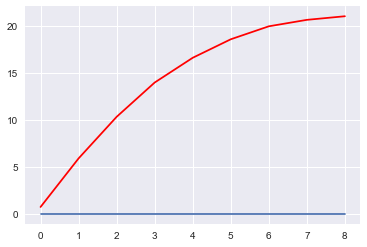

[ 21.03427457  20.65047229  19.964206    18.58346615  16.61473525
  13.98156228  10.3314677    5.90743397   0.73827   ]
--------------------------------------------
predicted=9.616337, expected=0.000000
predicted=9.771278, expected=0.000000
predicted=13.317357, expected=0.000000
predicted=15.686143, expected=0.000000
predicted=17.889999, expected=0.000000
predicted=19.269459, expected=0.000000
predicted=19.843510, expected=0.000000
predicted=20.738157, expected=0.000000
predicted=17.791205, expected=0.000000
predicted=17.968667, expected=0.000000
length=9
num=10
i=9
Test MSE: 276.272
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
   0.    0.    0. ]


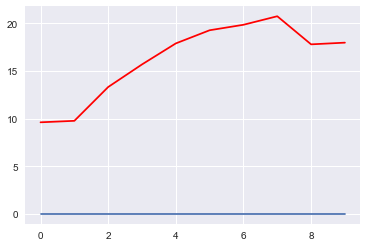

[ 17.95866739  17.78120477  20.7281568   19.83350987  19.25945885
  17.87999877  15.67614328  13.30735674   9.76127827   9.60633748]
--------------------------------------------
predicted=-1.594458, expected=0.000000
predicted=8.120203, expected=0.000000
predicted=8.788519, expected=0.000000
predicted=12.630579, expected=0.000000
predicted=15.176679, expected=0.000000
predicted=17.554037, expected=0.000000
predicted=19.113633, expected=0.000000
predicted=19.651858, expected=0.000000
predicted=21.514734, expected=0.000000
predicted=18.585738, expected=0.000000
predicted=18.807902, expected=0.000000
length=9
num=11
i=10
Test MSE: 250.376
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  

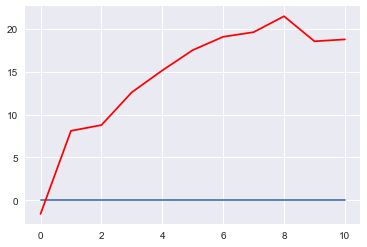

[ 18.79790219  18.57573784  21.50473362  19.64185839  19.10363308
  17.54403695  15.1666794   12.62057931   8.77851898   8.11020289
  -1.60445799]
--------------------------------------------
predicted=4.187827, expected=0.000000
predicted=2.041915, expected=0.000000
predicted=10.598316, expected=0.000000
predicted=11.783707, expected=0.000000
predicted=15.007108, expected=0.000000
predicted=16.845012, expected=0.000000
predicted=18.011596, expected=0.000000
predicted=19.798699, expected=0.000000
predicted=17.868109, expected=0.000000
predicted=19.392968, expected=0.000000
predicted=16.409576, expected=0.000000
predicted=15.895615, expected=0.000000
length=9
num=12
i=11
Test MSE: 226.017
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.   

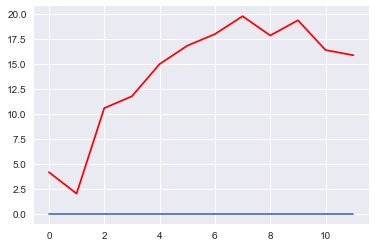

[ 15.88561491  16.39957604  19.38296805  17.85810902  19.78869942
  18.0015964   16.83501185  14.99710766  11.77370677  10.58831587
   2.03191476   4.17782709]
--------------------------------------------
predicted=2.570562, expected=0.000000
predicted=6.347611, expected=0.000000
predicted=3.529466, expected=0.000000
predicted=12.398136, expected=0.000000
predicted=13.083916, expected=0.000000
predicted=15.750804, expected=0.000000
predicted=16.668269, expected=0.000000
predicted=18.216587, expected=0.000000
predicted=18.599171, expected=0.000000
predicted=16.478082, expected=0.000000
predicted=18.147297, expected=0.000000
predicted=14.888086, expected=0.000000
predicted=14.657471, expected=0.000000
length=9
num=13
i=12
Test MSE: 201.683
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.

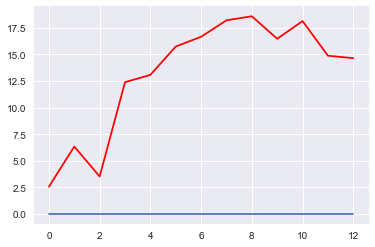

[ 14.6474705   14.87808603  18.13729721  16.46808205  18.58917093
  18.20658687  16.65826925  15.74080445  13.07391554  12.3881358
   3.51946576   6.33761103   2.56056162]
--------------------------------------------
predicted=-5.416732, expected=0.000000
predicted=-2.051214, expected=0.000000
predicted=3.093794, expected=0.000000
predicted=-0.303106, expected=0.000000
predicted=8.842495, expected=0.000000
predicted=11.030235, expected=0.000000
predicted=16.015930, expected=0.000000
predicted=15.724209, expected=0.000000
predicted=20.670772, expected=0.000000
predicted=21.725957, expected=0.000000
predicted=19.673338, expected=0.000000
predicted=21.458286, expected=0.000000
predicted=18.367609, expected=0.000000
predicted=17.937798, expected=0.000000
length=9
num=14
i=13
Test MSE: 224.959
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  

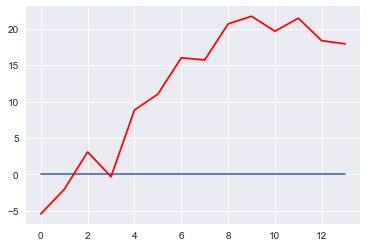

[ 17.92779805  18.35760892  21.44828569  19.66333833  21.71595721
  20.66077185  15.71420878  16.00593046  11.02023456   8.83249482
  -0.31310576   3.08379413  -2.06121414  -5.4267319 ]
--------------------------------------------
predicted=8.259066, expected=0.000000
predicted=1.918196, expected=0.000000
predicted=3.087066, expected=0.000000
predicted=7.837918, expected=0.000000
predicted=5.426398, expected=0.000000
predicted=12.992176, expected=0.000000
predicted=11.659491, expected=0.000000
predicted=18.678202, expected=0.000000
predicted=13.540872, expected=0.000000
predicted=17.129762, expected=0.000000
predicted=16.706797, expected=0.000000
predicted=16.001499, expected=0.000000
predicted=16.674902, expected=0.000000
predicted=13.054483, expected=0.000000
predicted=15.897416, expected=0.000000
length=9
num=15
i=14
Test MSE: 169.033
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20. 

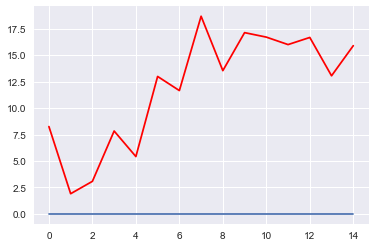

[ 15.88741586  13.04448285  16.66490168  15.99149872  16.69679738
  17.11976223  13.53087152  18.66820154  11.64949084  12.98217647
   5.4163978    7.82791759   3.07706643   1.90819643   8.24906595]
--------------------------------------------
predicted=5.276793, expected=0.000000
predicted=9.806185, expected=0.000000
predicted=13.606702, expected=0.000000
predicted=16.342613, expected=0.000000
predicted=18.393664, expected=0.000000
predicted=19.885147, expected=0.000000
predicted=20.610693, expected=0.000000
predicted=21.098010, expected=0.000000
predicted=20.842314, expected=0.000000
predicted=20.516125, expected=0.000000
length=10
num=10
i=9
Test MSE: 303.189
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0

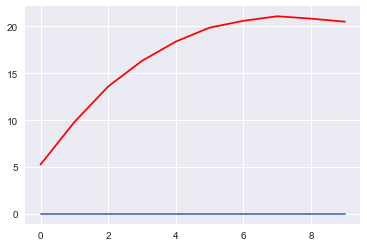

[ 20.50612496  20.83231399  21.08801004  20.60069341  19.87514682
  18.38366442  16.33261281  13.59670247   9.79618532   5.26679324]
--------------------------------------------
predicted=0.748270, expected=0.000000
predicted=5.917434, expected=0.000000
predicted=10.341468, expected=0.000000
predicted=13.991562, expected=0.000000
predicted=16.624735, expected=0.000000
predicted=18.593466, expected=0.000000
predicted=19.974206, expected=0.000000
predicted=20.660472, expected=0.000000
predicted=21.044275, expected=0.000000
predicted=20.768300, expected=0.000000
predicted=20.217327, expected=0.000000
length=10
num=11
i=10
Test MSE: 278.705
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. 

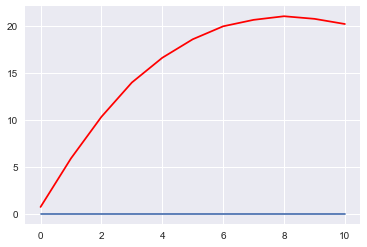

[ 20.20732687  20.75829986  21.03427457  20.65047229  19.964206
  18.58346615  16.61473525  13.98156228  10.3314677    5.90743397   0.73827   ]
--------------------------------------------
predicted=9.616337, expected=0.000000
predicted=9.771278, expected=0.000000
predicted=13.317357, expected=0.000000
predicted=15.686143, expected=0.000000
predicted=17.889999, expected=0.000000
predicted=19.269459, expected=0.000000
predicted=19.843510, expected=0.000000
predicted=20.738157, expected=0.000000
predicted=17.791205, expected=0.000000
predicted=17.968667, expected=0.000000
predicted=15.698004, expected=0.000000
predicted=14.170379, expected=0.000000
length=10
num=12
i=11
Test MSE: 267.446
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0

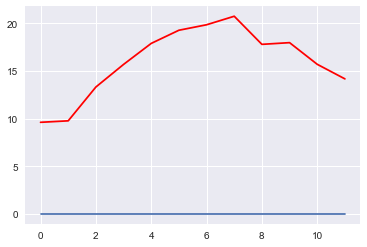

[ 14.16037903  15.68800448  17.95866739  17.78120477  20.7281568
  19.83350987  19.25945885  17.87999877  15.67614328  13.30735674
   9.76127827   9.60633748]
--------------------------------------------
predicted=-1.594458, expected=0.000000
predicted=8.120203, expected=0.000000
predicted=8.788519, expected=0.000000
predicted=12.630579, expected=0.000000
predicted=15.176679, expected=0.000000
predicted=17.554037, expected=0.000000
predicted=19.113633, expected=0.000000
predicted=19.651858, expected=0.000000
predicted=21.514734, expected=0.000000
predicted=18.585738, expected=0.000000
predicted=18.807902, expected=0.000000
predicted=16.563315, expected=0.000000
predicted=15.002106, expected=0.000000
length=10
num=13
i=12
Test MSE: 250.224
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26

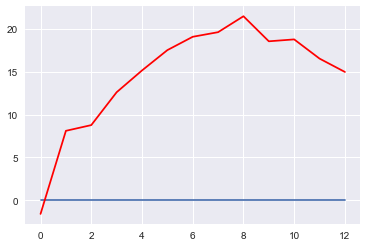

[ 14.99210644  16.5533149   18.79790219  18.57573784  21.50473362
  19.64185839  19.10363308  17.54403695  15.1666794   12.62057931
   8.77851898   8.11020289  -1.60445799]
--------------------------------------------
predicted=4.187827, expected=0.000000
predicted=2.041915, expected=0.000000
predicted=10.598316, expected=0.000000
predicted=11.783707, expected=0.000000
predicted=15.007108, expected=0.000000
predicted=16.845012, expected=0.000000
predicted=18.011596, expected=0.000000
predicted=19.798699, expected=0.000000
predicted=17.868109, expected=0.000000
predicted=19.392968, expected=0.000000
predicted=16.409576, expected=0.000000
predicted=15.895615, expected=0.000000
predicted=13.905348, expected=0.000000
predicted=12.425577, expected=0.000000
length=10
num=14
i=13
Test MSE: 218.531
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5

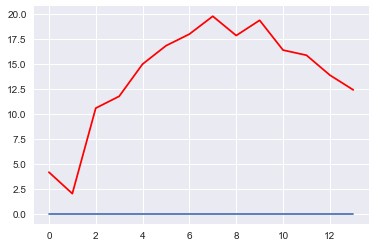

[ 12.41557661  13.89534773  15.88561491  16.39957604  19.38296805
  17.85810902  19.78869942  18.0015964   16.83501185  14.99710766
  11.77370677  10.58831587   2.03191476   4.17782709]
--------------------------------------------
predicted=2.570562, expected=0.000000
predicted=6.347611, expected=0.000000
predicted=3.529466, expected=0.000000
predicted=12.398136, expected=0.000000
predicted=13.083916, expected=0.000000
predicted=15.750804, expected=0.000000
predicted=16.668269, expected=0.000000
predicted=18.216587, expected=0.000000
predicted=18.599171, expected=0.000000
predicted=16.478082, expected=0.000000
predicted=18.147297, expected=0.000000
predicted=14.888086, expected=0.000000
predicted=14.657471, expected=0.000000
predicted=12.752006, expected=0.000000
predicted=12.155703, expected=0.000000
length=10
num=15
i=14
Test MSE: 195.450
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  2

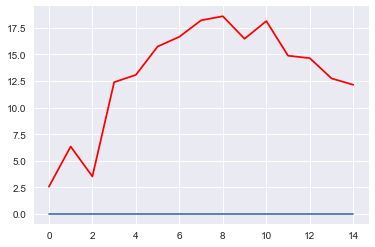

[ 12.14570283  12.74200573  14.6474705   14.87808603  18.13729721
  16.46808205  18.58917093  18.20658687  16.65826925  15.74080445
  13.07391554  12.3881358    3.51946576   6.33761103   2.56056162]
--------------------------------------------


In [104]:
### please read!! here if the model recognizes the pattern with high accuracy, then we may get many options depending on 
### different parameters when we generate the future forecasts, take 7201 JP as example if you want
### then from bottom up, check through the results, and choose the best result you think, 
### and then copy the corresponding 'length=?', 'num=?', and 'i=?', and assign the values again
temp1 = []
forecast = []
if temp != []:
    if dfsfinal['Ratio'].values[0] < 0.1:
        # 0.1 as the criterion of accuracy we require, 0.1 means 90% accuracy
        for length in range(1, 5*fre_dict[fre['DV016'].values[0]] + 1):
            time_order_div_length = np.append(time_order_div,[0]*length*fre_dict[fre['DV016'].values[0]])
            for num in range(length, fre_dict[fre['DV016'].values[0]]*8):
                try:
                    train, test = time_order_div_length[0:len(time_order_div_length)-num], time_order_div_length[len(time_order_div_length)-num:]   # train autoregression
                    model = AR(train)
                    # here we can use ARMA or AR or MA or ARIMA models we think are appropraite
                    model_fit = model.fit() 
                    # make prediction
                    predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
                    error = mean_squared_error(test, predictions)
                    temp1.append((tickername, model_fit.k_ar, num, error, time_order_div_length[-1]))
                    for i in range(len(predictions)):
                        print('predicted=%f, expected=%f' % (0.01 + predictions[i], test[i]))
                    error = mean_squared_error(test, predictions)
                    print('length='+ str(length) + '\nnum=' + str(num) +'\ni='+ str(i))
                    print('Test MSE: %.3f' % error)
                    print(time_order_div_length)
                    # plot results
                    pyplot.plot(test)
                    pyplot.plot(predictions, color='red')
                    pyplot.show()
                    forecast = predictions[::-1]
                    print(forecast)
                    print('--------------------------------------------')
                except ValueError:
                    continue
    else: 
        forecast.append(time_order_div[0-fre_dict[fre['DV016'].values[0]]:])
        forecast = forecast[0] *5
        print(forecast[::-1])
else: 
    forecast.append(time_order_div[0-fre_dict[fre['DV016'].values[0]]:])
    forecast = forecast[0] *5
    print(forecast[::-1])

In [105]:
length=7
num=15
i=14

predicted=28.692920, expected=28.500000
predicted=29.499249, expected=0.000000
predicted=29.117765, expected=0.000000
predicted=29.597794, expected=0.000000
predicted=29.866199, expected=0.000000
predicted=30.567502, expected=0.000000
predicted=30.986280, expected=0.000000
predicted=31.748908, expected=0.000000
predicted=32.301643, expected=0.000000
predicted=33.033324, expected=0.000000
predicted=33.576167, expected=0.000000
predicted=34.366954, expected=0.000000
predicted=35.015617, expected=0.000000
predicted=35.724583, expected=0.000000
predicted=36.294974, expected=0.000000
7 15 14
Test MSE: 976.153
[  7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.    7.
   3.    7.    4.   10.    8.   11.   12.   12.   14.   15.   17.   17.
  20.   20.   11.    5.    5.   10.   10.   12.5  12.5  15.   15.   16.5
  16.5  21.   21.   24.   24.   26.5  26.5  28.5  28.5   0.    0.    0.
   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0. ]


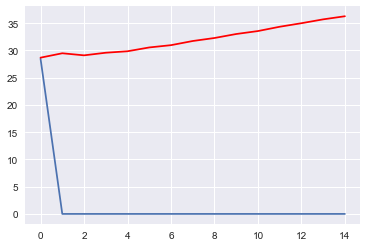

[ 36.28497378  35.71458271  35.00561744  34.35695442  33.56616687
  33.02332404  32.29164325  31.73890803  30.9762797   30.55750243
  29.85619913  29.58779404  29.10776487  29.48924876  28.68291969]


In [106]:
time_order_div_length = np.append(time_order_div,[0]*length*fre_dict[fre['DV016'].values[0]])
train, test = time_order_div_length[0:len(time_order_div_length)-num], time_order_div_length[len(time_order_div_length)-num:]   # train autoregression
model = AR(train)
# here we can use ARMA or AR or MA or ARIMA models we think are appropraite
model_fit = model.fit() 
# make prediction
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
error = mean_squared_error(test, predictions)
temp1.append((tickername, model_fit.k_ar, num, error, time_order_div_length[-1]))
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (0.01 + predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print(length, num, i)
print('Test MSE: %.3f' % error)
print(time_order_div_length)
# plot results
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()
forecast = predictions[::-1]
print(forecast)

In [107]:
dataframe = {'declarationDate': adjustedecdate, 'exDate': exdate, 'entryDate': entrydate, 
            'recordDate': finalrecorddate, 'payDate': adjustepaydate, 'fiscalYear': fiscalyear, 'fiscalPeriod': fiscalperiod,
            'value': forecast[0-min(5*fre_dict[fre['DV016'].values[0]], len(forecast)):], 
            'trendTool': forecast[0-min(5*fre_dict[fre['DV016'].values[0]], len(forecast)):], 'timesAYear':timesayear, 'dividendType': dividendtype, 'currency': currency, 
            'netOrGross': netorgross, 'note': ['']*5*fre_dict[fre['DV016'].values[0]], 'dividendForecastId': ['']*5*fre_dict[fre['DV016'].values[0]]}


In [108]:
for i in dataframe:
    print(i)
    print(len(dataframe[i]))


value
10
payDate
10
dividendForecastId
10
fiscalPeriod
10
currency
10
declarationDate
10
fiscalYear
10
exDate
10
trendTool
10
dividendType
10
timesAYear
10
note
10
netOrGross
10
recordDate
10
entryDate
10


In [109]:
df = pd.DataFrame(dataframe, columns = ['declarationDate', 'exDate', 'entryDate', 'recordDate', 'payDate', 'fiscalYear', 'fiscalPeriod', 'value', 'trendTool', 'timesAYear', 'dividendType', 'currency', 'netOrGross', 'note', 'dividendForecastId'])

In [110]:
df

,declarationDate,exDate,entryDate,recordDate,payDate,fiscalYear,fiscalPeriod,value,trendTool,timesAYear,dividendType,currency,netOrGross,note,dividendForecastId
0,11/07/2023,03/28/2024,07/05/2019,03/31/2024,06/24/2025,2024,S2,33.0233,33.0233,2,FINAL,JPY,NONE,,
1,05/15/2023,09/28/2023,07/05/2019,09/30/2023,11/26/2024,2024,S1,32.2916,32.2916,2,INTERIM,JPY,NONE,,
2,11/07/2022,03/30/2023,07/05/2019,03/31/2023,06/24/2024,2023,S2,31.7389,31.7389,2,FINAL,JPY,NONE,,
3,05/13/2022,09/29/2022,07/05/2019,09/30/2022,11/27/2023,2023,S1,30.9763,30.9763,2,INTERIM,JPY,NONE,,
4,11/08/2021,03/30/2022,07/05/2019,03/31/2022,06/26/2023,2022,S2,30.5575,30.5575,2,FINAL,JPY,NONE,,
5,05/13/2021,09/29/2021,07/05/2019,09/30/2021,11/28/2022,2022,S1,29.8562,29.8562,2,INTERIM,JPY,NONE,,
6,11/09/2020,03/30/2021,07/05/2019,03/31/2021,06/27/2022,2021,S2,29.5878,29.5878,2,FINAL,JPY,NONE,,
7,05/13/2020,09/29/2020,07/05/2019,09/30/2020,11/29/2021,2021,S1,29.1078,29.1078,2,INTERIM,JPY,NONE,,
8,11/08/2019,03/30/2020,07/05/2019,03/31/2020,06/25/2021,2020,S2,29.4892,29.4892,2,FINAL,JPY,NONE,,
9,05/14/2019,09/27/2019,07/05/2019,09/30/2019,11/27/2020,2020,S1,28.6829,28.6829,2,INTERIM,JPY,NONE,,


In [115]:
df.to_excel(tickername + '.xlsx', index = False)